In [104]:
pip install tqdm

  Obtaining dependency information for tqdm from https://files.pythonhosted.org/packages/18/eb/fdb7eb9e48b7b02554e1664afd3bd3f117f6b6d6c5881438a0b055554f9b/tqdm-4.66.4-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 791.1 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 621.6 kB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.2.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import time

In [5]:
symbol = 'BTC/USDT'
timeframe = '1h'
ma_short_period = 20
ma_long_period = 50
balance_percentage = 0.1

In [48]:
data = pd.read_csv("/Users/karimmeguenni-tani/Bot project trading/Cryptobot/DataBase/1h/BTC-USDT-USDT.csv")
data.index = pd.to_datetime(data['date'], unit='ms')
data = data.drop('date', axis=1)


In [96]:
data

,open,high,low,close,volume,ma_short,ma_long,short_ma,long_ma
date,,,,,,,,,
2019-07-10 11:00:00,13073.5,13075.5,13044.5,13064.5,4.8952,NaN,NaN,NaN,NaN
2019-07-10 12:00:00,13064.5,13064.5,12900.5,13029.0,684.5329,NaN,NaN,NaN,NaN
2019-07-10 13:00:00,13029.0,13127.5,12996.5,13039.5,812.2584,NaN,NaN,NaN,NaN
2019-07-10 14:00:00,13039.5,13065.5,12549.5,12549.5,679.7040,NaN,NaN,NaN,NaN
2019-07-10 15:00:00,12549.5,12552.0,12121.0,12362.0,715.6550,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2024-04-19 23:00:00,63964.2,64095.3,62890.7,63771.2,14875.2400,64205.825,63021.072,63021.072,64784.0225
2024-04-20 00:00:00,63771.2,64216.4,63365.5,63401.3,8151.1100,64255.820,63056.176,63056.176,64750.8675
2024-04-20 01:00:00,63401.3,63741.9,63031.2,63606.8,7683.9050,64334.010,63103.592,63103.592,64717.8020


In [16]:
def calculate_ma(data):
    data['ma_short'] = data['close'].rolling(window=ma_short_period).mean()
    data['ma_long'] = data['close'].rolling(window=ma_long_period).mean()
    return data

In [10]:
def trading_strategy(data):
    if data['ma_short'].iloc[-1] > data['ma_long'].iloc[-1] and data['ma_short'].iloc[-2] <= data['ma_long'].iloc[-2]:
        return 'buy'
    elif data['ma_short'].iloc[-1] < data['ma_long'].iloc[-1] and data['ma_short'].iloc[-2] >= data['ma_long'].iloc[-2]:
        return 'sell'
    else:
        return 'hold'

In [67]:
def i_trading_strategy(data, index):
    n = 1
    previous_rows = data.loc[:index].tail(n+1).head(n)
    if data['ma_short'].loc[index] > data['ma_long'].loc[index] and previous_rows['ma_short'].iloc[0] <= previous_rows['ma_long'].iloc[0]:
        return 'buy'
    elif data['ma_short'].loc[index] < data['ma_long'].loc[index] and previous_rows['ma_short'].iloc[0] >= previous_rows['ma_long'].iloc[0]:
        return 'sell'
    else:
        return 'hold'
    

In [18]:
trade_records={"wallet":0,"symbol":"BTC/USDT","Coin":"BTC","trade_status":"Buy","value_usdt":0,"value_coin":0,"date":time.time(),"timeframe":"1h"}
print(list(trade_records.keys()))
historical_trades_records = pd.DataFrame(columns=list(trade_records.keys()))
historical_trades_records

['wallet', 'symbol', 'Coin', 'trade_status', 'value_usdt', 'value_coin', 'date', 'timeframe']


,wallet,symbol,Coin,trade_status,value_usdt,value_coin,date,timeframe


In [66]:
def calculate_value_wallet(wallet,data):
    return wallet['usdt'] + wallet['coin'] * data['close'].iloc[-1]
def i_calculate_value_wallet(wallet,row):
    return wallet['usdt'] + wallet['coin'] * row['close']

In [50]:
condition=True

wallet={"usdt":1000,"coin":0}
parameters={"wallet":calculate_value_wallet(wallet,data),"taker_fee":0.1,"maker_fee":0.1,"balance_percentage_usdt":0.1,"balance_percentage_coin":1,"symbol":"BTC/USDT","num_trades":0,"trade_status":"None"}
parameters_records = pd.DataFrame(parameters, index=[0])
trade_records={"symbol":"BTC/USDT","Coin":"BTC","trade_status":"Buy","value_usdt":0,"value_coin":0,"date":time.time(),"timeframe":"1h"}
historical_trades_records = pd.DataFrame(columns=list(trade_records.keys()))

data = calculate_ma(data)
# Create a new dataframe with a single row using the parameters dictionary
while condition:
    # Obtenir l'heure actuelle
    current_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())

    # Vérifier si l'on doit acheter ou vendre
    action = trading_strategy(data)
    print("value action:",action)
    # Effectuer les calculs d'achat ou de vente en fonction des paramètres
    if action == 'buy' and parameters['wallet']['usdt'] > 0 and parameters['trade_status'] != 'Bought':
        # Calculer la valeur de l'achat
        value_usdt = (1 - parameters['taker_fee']) * parameters['balance_percentage_usdt'] * parameters['wallet']['usdt']
        value_coin = value_usdt / data['close'].iloc[-1]
        # Mettre à jour les paramètres
        wallet={"usdt":value_usdt,"coin":value_coin}
        parameters['wallet'] = calculate_value_wallet(wallet,data)
        parameters['num_trades'] += 1
        parameters['trade_status'] = 'Bought'
        # Stocker les résultats dans parameters_records
        parameters_records = parameters_records.append(parameters, ignore_index=True)
        # Stocker les résultats dans trade_records
        trade_records = {'symbol': parameters['symbol'], 'trade_status': 'Buy', 'value_usdt': value_usdt, 'value_coin': value_coin, 'date': current_time, 'timeframe': parameters['timeframe']}
        # Stocker les résultats dans historical_trades_records
        historical_trades_records = historical_trades_records.append(trade_records, ignore_index=True)
    elif action == 'sell' and parameters['wallet']['coin'] > 0:
        # Calculer la valeur de la vente
        value_coin =  (1 - parameters['maker_fee']) * (1-parameters['balance_percentage_coin']) * parameters['wallet']['coin']
        value_usdt =  value_coin * data['close'].iloc[-1]
        # Mettre à jour les paramètres
        parameters['wallet'] = calculate_value_wallet(wallet,data)
        parameters['num_trades'] += 1
        parameters['trade_status'] = 'Sold'
        # Stocker les résultats dans parameters_records
        parameters_records = parameters_records.append(parameters, ignore_index=True)
        # Stocker les résultats dans trade_records
        trade_records = {'symbol': parameters['symbol'], 'trade_status': 'Sell', 'value_usdt': value_usdt, 'value_coin': value_coin, 'date': current_time, 'timeframe': parameters['timeframe']}
        display(trade_records)
        # Stocker les résultats dans historical_trades_records
        historical_trades_records = historical_trades_records.append(trade_records, ignore_index=True)
    
    # Attendre une heure avant la prochaine itération
    condition=False


value action: hold


Test brouillon Backtest

In [90]:
condition = True

wallet_start = {"usdt": 1000, "coin": 0}
parameters = {
    "wallet": calculate_value_wallet(wallet, data),
    "usdt": 1000,
    "coin": 0,
    "taker_fee": 0.01,
    "maker_fee": 0.01,
    "balance_percentage_usdt": 0.1,
    "balance_percentage_coin": 1,
    "symbol": "BTC/USDT",
    "num_trades": 0,
    "trade_status": "None",
}
parameters_records = pd.DataFrame(columns=list(parameters.keys()))

trade_records = {
    "symbol": "BTC/USDT",
    "Coin": "BTC",
    "trade_status": "Buy",
    "value_usdt": 0,
    "value_coin": 0,
    "date": time.time(),
    "timeframe": "1h",
}
historical_trades_records = pd.DataFrame(columns=list(trade_records.keys()))

data = calculate_ma(data)


def i_calculate_value_wallet(wallet, row):
    return wallet["usdt"] + wallet["coin"] * row["close"]


def get_values_usdt_coin(parameters, row, action):
    value_usdt = parameters["usdt"]
    value_coin = parameters["coin"]
    if action == "buy" and parameters["trade_status"] != "Bought":
        value_usdt = (
            value_usdt - parameters["balance_percentage_usdt"] * parameters["usdt"]
        )
        value_coin = (1 - parameters["taker_fee"]) * value_usdt / row["close"]
    elif action == "sell" and parameters["trade_status"] != "Sell":
        value_coin = (
            value_coin - parameters["balance_percentage_coin"] * parameters["coin"]
        )
        value_usdt = (1 - parameters["maker_fee"]) * value_coin * row["close"]
    return value_usdt, value_coin


def set_parameters_values(parameters, value_usdt, value_coin, row, action):
    if (
        action == "buy"
        and parameters["usdt"] > 10
        and parameters["trade_status"] != "Bought"
    ):
        wallet = {"usdt": value_usdt, "coin": value_coin}
        parameters["wallet"] = i_calculate_value_wallet(wallet, row)
        parameters["num_trades"] += 1
        parameters["trade_status"] = "Bought"
    elif (
        action == "sell"
        and parameters["coin"] > 0
        and parameters["trade_status"] != "Sold"
    ):
        wallet = {"usdt": value_usdt, "coin": value_coin}
        parameters["wallet"] = i_calculate_value_wallet(wallet, row)
        parameters["num_trades"] += 1
        parameters["trade_status"] = "Sold"
    elif action == "buy" and parameters["trade_status"] == "Bought":
        wallet = {"usdt": value_usdt, "coin": value_coin}
        parameters["wallet"] = i_calculate_value_wallet(wallet, row)
    elif action == "sell" and parameters["trade_status"] == "Sold":
        wallet = {"usdt": value_usdt, "coin": value_coin}
        parameters["wallet"] = i_calculate_value_wallet(wallet, row)
    return parameters


def i_trade(data, parameters, index, n_previous_rows):
    """
    Perform trading operations based on the given data, parameters, index, and number of previous rows.

    Args:
        data (DataFrame): The data used for trading operations.
        parameters (DataFrame): The parameters used for trading calculations.
        index (datetime): The current time index.
        n_previous_rows (int): The number of previous rows to consider for calculations.

    Returns:
        None
    """

    # Obtain the current time
    current_time = index
    print(index)

    # Obtain the current parameter
    if not parameters_records.empty:
        parameters = parameters_records.iloc[-1]
    # Check if we should buy or sell
    action = i_trading_strategy(data, index)
    # Retrieve the previous n rows of the trade
    previous_rows = data.loc[:index].tail(n_previous_rows + 1).head(n_previous_rows)
    row = data.loc[index]

    # Perform buy or sell calculations based on the parameters
    if (
        action == "buy"
        and parameters["usdt"] > 10
        and parameters["trade_status"] != "Bought"
    ):
        # Calculate the value of the purchase
        value_usdt, value_coin = get_values_usdt_coin(parameters, row, action)
        parameters = set_parameters_values(
            parameters, value_usdt, value_coin, row, action
        )
        parameters_records.loc[index] = parameters
        # Store the results in trade_records
        trade_records = {
            "symbol": parameters["symbol"],
            "trade_status": "Buy",
            "value_usdt": value_usdt,
            "value_coin": value_coin,
            "date": current_time,
            "timeframe": timeframe,
        }
        # Store the results in historical_trades_records
        historical_trades_records.loc[
            time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
        ] = trade_records
    elif (
        action == "sell"
        and parameters["coin"] > 0
        and parameters["trade_status"] != "Sell"
    ):
        # Calculate the value of the sale
        value_usdt, value_coin = get_values_usdt_coin(parameters, row, action)
        parameters = set_parameters_values(
            parameters, value_usdt, value_coin, row, action
        )
        # Store the results in parameters_records
        parameters_records.loc[index] = parameters
        # Store the results in trade_records
        trade_records = {
            "symbol": parameters["symbol"],
            "trade_status": "Sell",
            "value_usdt": value_usdt,
            "value_coin": value_coin,
            "date": current_time,
            "timeframe": timeframe,
        }
        # Store the results in historical_trades_records
        historical_trades_records.loc[
            time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
        ] = trade_records
    elif action == "buy" and parameters["trade_status"] == "Bought":
        value_usdt, value_coin = get_values_usdt_coin(parameters, row, action)
        parameters = set_parameters_values(
            parameters, value_usdt, value_coin, row, action
        )
        parameters_records.loc[index] = parameters
    elif action == "sell" and parameters["trade_status"] == "Sold":
        value_usdt, value_coin = get_values_usdt_coin(parameters, row, action)
        parameters = set_parameters_values(
            parameters, value_usdt, value_coin, row, action
        )
        parameters_records.loc[index] = parameters

In [92]:
df=data.copy()
df=calculate_ma(df)
wallet={"usdt":1000,"coin":0}
parameter={"wallet":calculate_value_wallet(wallet,df),"taker_fee":0.1,"maker_fee":0.1,"balance_percentage_usdt":0.1,"balance_percentage_coin":1,"symbol":"BTC/USDT","num_trades":0,"trade_status":"None"}
parameters_records = pd.DataFrame(columns=list(parameters.keys()))

trade_records={"symbol":"BTC/USDT","Coin":"BTC","trade_status":"Buy","value_usdt":0,"value_coin":0,"date":time.time(),"timeframe":"1h"}
historical_trades_records = pd.DataFrame(columns=list(trade_records.keys()))
for index, row in df.iterrows():
    i_trade(df, parameters, index, 1)



2019-07-10 11:00:00
2019-07-10 12:00:00
2019-07-10 13:00:00
2019-07-10 14:00:00
2019-07-10 15:00:00
2019-07-10 16:00:00
2019-07-10 17:00:00
2019-07-10 18:00:00
2019-07-10 19:00:00
2019-07-10 20:00:00
2019-07-10 21:00:00
2019-07-10 22:00:00
2019-07-10 23:00:00
2019-07-11 00:00:00
2019-07-11 01:00:00
2019-07-11 02:00:00
2019-07-11 03:00:00
2019-07-11 04:00:00
2019-07-11 05:00:00
2019-07-11 06:00:00
2019-07-11 07:00:00
2019-07-11 08:00:00
2019-07-11 09:00:00
2019-07-11 10:00:00
2019-07-11 11:00:00
2019-07-11 12:00:00
2019-07-11 13:00:00
2019-07-11 14:00:00
2019-07-11 15:00:00
2019-07-11 16:00:00
2019-07-11 17:00:00
2019-07-11 18:00:00
2019-07-11 19:00:00
2019-07-11 20:00:00
2019-07-11 21:00:00
2019-07-11 22:00:00
2019-07-11 23:00:00
2019-07-12 00:00:00
2019-07-12 01:00:00
2019-07-12 02:00:00
2019-07-12 03:00:00
2019-07-12 04:00:00
2019-07-12 05:00:00
2019-07-12 06:00:00
2019-07-12 07:00:00
2019-07-12 08:00:00
2019-07-12 09:00:00
2019-07-12 10:00:00
2019-07-12 11:00:00
2019-07-12 12:00:00


/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

2019-08-11 01:00:00
2019-08-11 02:00:00
2019-08-11 03:00:00
2019-08-11 04:00:00
2019-08-11 05:00:00
2019-08-11 06:00:00
2019-08-11 07:00:00
2019-08-11 08:00:00
2019-08-11 09:00:00
2019-08-11 10:00:00
2019-08-11 11:00:00
2019-08-11 12:00:00
2019-08-11 13:00:00
2019-08-11 14:00:00
2019-08-11 15:00:00
2019-08-11 16:00:00
2019-08-11 17:00:00
2019-08-11 18:00:00
2019-08-11 19:00:00
2019-08-11 20:00:00
2019-08-11 21:00:00
2019-08-11 22:00:00
2019-08-11 23:00:00
2019-08-12 00:00:00
2019-08-12 01:00:00
2019-08-12 02:00:00
2019-08-12 03:00:00
2019-08-12 04:00:00
2019-08-12 05:00:00
2019-08-12 06:00:00
2019-08-12 07:00:00
2019-08-12 08:00:00
2019-08-12 09:00:00
2019-08-12 10:00:00
2019-08-12 11:00:00
2019-08-12 12:00:00
2019-08-12 13:00:00
2019-08-12 14:00:00
2019-08-12 15:00:00
2019-08-12 16:00:00
2019-08-12 17:00:00
2019-08-12 18:00:00
2019-08-12 19:00:00
2019-08-12 20:00:00
2019-08-12 21:00:00
2019-08-12 22:00:00
2019-08-12 23:00:00
2019-08-13 00:00:00
2019-08-13 01:00:00
2019-08-13 02:00:00


/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

2019-09-09 05:00:00
2019-09-09 06:00:00
2019-09-09 07:00:00
2019-09-09 08:00:00
2019-09-09 09:00:00
2019-09-09 10:00:00
2019-09-09 11:00:00
2019-09-09 12:00:00
2019-09-09 13:00:00
2019-09-09 14:00:00
2019-09-09 15:00:00
2019-09-09 16:00:00
2019-09-09 17:00:00
2019-09-09 18:00:00
2019-09-09 19:00:00
2019-09-09 20:00:00
2019-09-09 21:00:00
2019-09-09 22:00:00
2019-09-09 23:00:00
2019-09-10 00:00:00
2019-09-10 01:00:00
2019-09-10 02:00:00
2019-09-10 03:00:00
2019-09-10 04:00:00
2019-09-10 05:00:00
2019-09-10 06:00:00
2019-09-10 07:00:00
2019-09-10 08:00:00
2019-09-10 09:00:00
2019-09-10 10:00:00
2019-09-10 11:00:00
2019-09-10 12:00:00
2019-09-10 13:00:00
2019-09-10 14:00:00
2019-09-10 15:00:00
2019-09-10 16:00:00
2019-09-10 17:00:00
2019-09-10 18:00:00
2019-09-10 19:00:00
2019-09-10 20:00:00
2019-09-10 21:00:00
2019-09-10 22:00:00
2019-09-10 23:00:00
2019-09-11 00:00:00
2019-09-11 01:00:00
2019-09-11 02:00:00
2019-09-11 03:00:00
2019-09-11 04:00:00
2019-09-11 05:00:00
2019-09-11 06:00:00


/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

2019-10-04 05:00:00
2019-10-04 06:00:00
2019-10-04 07:00:00
2019-10-04 08:00:00
2019-10-04 09:00:00
2019-10-04 10:00:00
2019-10-04 11:00:00
2019-10-04 12:00:00
2019-10-04 13:00:00
2019-10-04 14:00:00
2019-10-04 15:00:00
2019-10-04 16:00:00
2019-10-04 17:00:00
2019-10-04 18:00:00
2019-10-04 19:00:00
2019-10-04 20:00:00
2019-10-04 21:00:00
2019-10-04 22:00:00
2019-10-04 23:00:00
2019-10-05 00:00:00
2019-10-05 01:00:00
2019-10-05 02:00:00
2019-10-05 03:00:00
2019-10-05 04:00:00
2019-10-05 05:00:00
2019-10-05 06:00:00
2019-10-05 07:00:00
2019-10-05 08:00:00
2019-10-05 09:00:00
2019-10-05 10:00:00
2019-10-05 11:00:00
2019-10-05 12:00:00
2019-10-05 13:00:00
2019-10-05 14:00:00
2019-10-05 15:00:00
2019-10-05 16:00:00
2019-10-05 17:00:00
2019-10-05 18:00:00
2019-10-05 19:00:00
2019-10-05 20:00:00
2019-10-05 21:00:00
2019-10-05 22:00:00
2019-10-05 23:00:00
2019-10-06 00:00:00
2019-10-06 01:00:00
2019-10-06 02:00:00
2019-10-06 03:00:00
2019-10-06 04:00:00
2019-10-06 05:00:00
2019-10-06 06:00:00


/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

2019-10-29 08:00:00
2019-10-29 09:00:00
2019-10-29 10:00:00
2019-10-29 11:00:00
2019-10-29 12:00:00
2019-10-29 13:00:00
2019-10-29 14:00:00
2019-10-29 15:00:00
2019-10-29 16:00:00
2019-10-29 17:00:00
2019-10-29 18:00:00
2019-10-29 19:00:00
2019-10-29 20:00:00
2019-10-29 21:00:00
2019-10-29 22:00:00
2019-10-29 23:00:00
2019-10-30 00:00:00
2019-10-30 01:00:00
2019-10-30 02:00:00
2019-10-30 03:00:00
2019-10-30 04:00:00
2019-10-30 05:00:00
2019-10-30 06:00:00
2019-10-30 07:00:00
2019-10-30 08:00:00
2019-10-30 09:00:00
2019-10-30 10:00:00
2019-10-30 11:00:00
2019-10-30 12:00:00
2019-10-30 13:00:00
2019-10-30 14:00:00
2019-10-30 15:00:00
2019-10-30 16:00:00
2019-10-30 17:00:00
2019-10-30 18:00:00
2019-10-30 19:00:00
2019-10-30 20:00:00
2019-10-30 21:00:00
2019-10-30 22:00:00
2019-10-30 23:00:00
2019-10-31 00:00:00
2019-10-31 01:00:00
2019-10-31 02:00:00
2019-10-31 03:00:00
2019-10-31 04:00:00
2019-10-31 05:00:00
2019-10-31 06:00:00
2019-10-31 07:00:00
2019-10-31 08:00:00
2019-10-31 09:00:00


/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

2019-12-02 04:00:00
2019-12-02 05:00:00
2019-12-02 06:00:00
2019-12-02 07:00:00
2019-12-02 08:00:00
2019-12-02 09:00:00
2019-12-02 10:00:00
2019-12-02 11:00:00
2019-12-02 12:00:00
2019-12-02 13:00:00
2019-12-02 14:00:00
2019-12-02 15:00:00
2019-12-02 16:00:00
2019-12-02 17:00:00
2019-12-02 18:00:00
2019-12-02 19:00:00
2019-12-02 20:00:00
2019-12-02 21:00:00
2019-12-02 22:00:00
2019-12-02 23:00:00
2019-12-03 00:00:00
2019-12-03 01:00:00
2019-12-03 02:00:00
2019-12-03 03:00:00
2019-12-03 04:00:00
2019-12-03 05:00:00
2019-12-03 06:00:00
2019-12-03 07:00:00
2019-12-03 08:00:00
2019-12-03 09:00:00
2019-12-03 10:00:00
2019-12-03 11:00:00
2019-12-03 12:00:00
2019-12-03 13:00:00
2019-12-03 14:00:00
2019-12-03 15:00:00
2019-12-03 16:00:00
2019-12-03 17:00:00
2019-12-03 18:00:00
2019-12-03 19:00:00
2019-12-03 20:00:00
2019-12-03 21:00:00
2019-12-03 22:00:00
2019-12-03 23:00:00
2019-12-04 00:00:00
2019-12-04 01:00:00
2019-12-04 02:00:00
2019-12-04 03:00:00
2019-12-04 04:00:00
2019-12-04 05:00:00


/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

2019-12-31 10:00:00
2019-12-31 11:00:00
2019-12-31 12:00:00
2019-12-31 13:00:00
2019-12-31 14:00:00
2019-12-31 15:00:00
2019-12-31 16:00:00
2019-12-31 17:00:00
2019-12-31 18:00:00
2019-12-31 19:00:00
2019-12-31 20:00:00
2019-12-31 21:00:00
2019-12-31 22:00:00
2019-12-31 23:00:00
2020-01-01 00:00:00
2020-01-01 01:00:00
2020-01-01 02:00:00
2020-01-01 03:00:00
2020-01-01 04:00:00
2020-01-01 05:00:00
2020-01-01 06:00:00
2020-01-01 07:00:00
2020-01-01 08:00:00
2020-01-01 09:00:00
2020-01-01 10:00:00
2020-01-01 11:00:00
2020-01-01 12:00:00
2020-01-01 13:00:00
2020-01-01 14:00:00
2020-01-01 15:00:00
2020-01-01 16:00:00
2020-01-01 17:00:00
2020-01-01 18:00:00
2020-01-01 19:00:00
2020-01-01 20:00:00
2020-01-01 21:00:00
2020-01-01 22:00:00
2020-01-01 23:00:00
2020-01-02 00:00:00
2020-01-02 01:00:00
2020-01-02 02:00:00
2020-01-02 03:00:00
2020-01-02 04:00:00
2020-01-02 05:00:00
2020-01-02 06:00:00
2020-01-02 07:00:00
2020-01-02 08:00:00
2020-01-02 09:00:00
2020-01-02 10:00:00
2020-01-02 11:00:00


/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

2020-03-04 08:00:00
2020-03-04 09:00:00
2020-03-04 10:00:00
2020-03-04 11:00:00
2020-03-04 12:00:00
2020-03-04 13:00:00
2020-03-04 14:00:00
2020-03-04 15:00:00
2020-03-04 16:00:00
2020-03-04 17:00:00
2020-03-04 18:00:00
2020-03-04 19:00:00
2020-03-04 20:00:00
2020-03-04 21:00:00
2020-03-04 22:00:00
2020-03-04 23:00:00
2020-03-05 00:00:00
2020-03-05 01:00:00
2020-03-05 02:00:00
2020-03-05 03:00:00
2020-03-05 04:00:00
2020-03-05 05:00:00
2020-03-05 06:00:00
2020-03-05 07:00:00
2020-03-05 08:00:00
2020-03-05 09:00:00
2020-03-05 10:00:00
2020-03-05 11:00:00
2020-03-05 12:00:00
2020-03-05 13:00:00
2020-03-05 14:00:00
2020-03-05 15:00:00
2020-03-05 16:00:00
2020-03-05 17:00:00
2020-03-05 18:00:00
2020-03-05 19:00:00
2020-03-05 20:00:00
2020-03-05 21:00:00
2020-03-05 22:00:00
2020-03-05 23:00:00
2020-03-06 00:00:00
2020-03-06 01:00:00
2020-03-06 02:00:00
2020-03-06 03:00:00
2020-03-06 04:00:00
2020-03-06 05:00:00
2020-03-06 06:00:00
2020-03-06 07:00:00
2020-03-06 08:00:00
2020-03-06 09:00:00


/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

2020-04-02 00:00:00
2020-04-02 01:00:00
2020-04-02 02:00:00
2020-04-02 03:00:00
2020-04-02 04:00:00
2020-04-02 05:00:00
2020-04-02 06:00:00
2020-04-02 07:00:00
2020-04-02 08:00:00
2020-04-02 09:00:00
2020-04-02 10:00:00
2020-04-02 11:00:00
2020-04-02 12:00:00
2020-04-02 13:00:00
2020-04-02 14:00:00
2020-04-02 15:00:00
2020-04-02 16:00:00
2020-04-02 17:00:00
2020-04-02 18:00:00
2020-04-02 19:00:00
2020-04-02 20:00:00
2020-04-02 21:00:00
2020-04-02 22:00:00
2020-04-02 23:00:00
2020-04-03 00:00:00
2020-04-03 01:00:00
2020-04-03 02:00:00
2020-04-03 03:00:00
2020-04-03 04:00:00
2020-04-03 05:00:00
2020-04-03 06:00:00
2020-04-03 07:00:00
2020-04-03 08:00:00
2020-04-03 09:00:00
2020-04-03 10:00:00
2020-04-03 11:00:00
2020-04-03 12:00:00
2020-04-03 13:00:00
2020-04-03 14:00:00
2020-04-03 15:00:00
2020-04-03 16:00:00
2020-04-03 17:00:00
2020-04-03 18:00:00
2020-04-03 19:00:00
2020-04-03 20:00:00
2020-04-03 21:00:00
2020-04-03 22:00:00
2020-04-03 23:00:00
2020-04-04 00:00:00
2020-04-04 01:00:00


/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

2020-04-27 22:00:00
2020-04-27 23:00:00
2020-04-28 00:00:00
2020-04-28 01:00:00
2020-04-28 02:00:00
2020-04-28 03:00:00
2020-04-28 04:00:00
2020-04-28 05:00:00
2020-04-28 06:00:00
2020-04-28 07:00:00
2020-04-28 08:00:00
2020-04-28 09:00:00
2020-04-28 10:00:00
2020-04-28 11:00:00
2020-04-28 12:00:00
2020-04-28 13:00:00
2020-04-28 14:00:00
2020-04-28 15:00:00
2020-04-28 16:00:00
2020-04-28 17:00:00
2020-04-28 18:00:00
2020-04-28 19:00:00
2020-04-28 20:00:00
2020-04-28 21:00:00
2020-04-28 22:00:00
2020-04-28 23:00:00
2020-04-29 00:00:00
2020-04-29 01:00:00
2020-04-29 02:00:00
2020-04-29 03:00:00
2020-04-29 04:00:00
2020-04-29 05:00:00
2020-04-29 06:00:00
2020-04-29 07:00:00
2020-04-29 08:00:00
2020-04-29 09:00:00
2020-04-29 10:00:00
2020-04-29 11:00:00
2020-04-29 12:00:00
2020-04-29 13:00:00
2020-04-29 14:00:00
2020-04-29 15:00:00
2020-04-29 16:00:00
2020-04-29 17:00:00
2020-04-29 18:00:00
2020-04-29 19:00:00
2020-04-29 20:00:00
2020-04-29 21:00:00
2020-04-29 22:00:00
2020-04-29 23:00:00


/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

2020-05-27 08:00:00
2020-05-27 09:00:00
2020-05-27 10:00:00
2020-05-27 11:00:00
2020-05-27 12:00:00
2020-05-27 13:00:00
2020-05-27 14:00:00
2020-05-27 15:00:00
2020-05-27 16:00:00
2020-05-27 17:00:00
2020-05-27 18:00:00
2020-05-27 19:00:00
2020-05-27 20:00:00
2020-05-27 21:00:00
2020-05-27 22:00:00
2020-05-27 23:00:00
2020-05-28 00:00:00
2020-05-28 01:00:00
2020-05-28 02:00:00
2020-05-28 03:00:00
2020-05-28 04:00:00
2020-05-28 05:00:00
2020-05-28 06:00:00
2020-05-28 07:00:00
2020-05-28 08:00:00
2020-05-28 09:00:00
2020-05-28 10:00:00
2020-05-28 11:00:00
2020-05-28 12:00:00
2020-05-28 13:00:00
2020-05-28 14:00:00
2020-05-28 15:00:00
2020-05-28 16:00:00
2020-05-28 17:00:00
2020-05-28 18:00:00
2020-05-28 19:00:00
2020-05-28 20:00:00
2020-05-28 21:00:00
2020-05-28 22:00:00
2020-05-28 23:00:00
2020-05-29 00:00:00
2020-05-29 01:00:00
2020-05-29 02:00:00
2020-05-29 03:00:00
2020-05-29 04:00:00
2020-05-29 05:00:00
2020-05-29 06:00:00
2020-05-29 07:00:00
2020-05-29 08:00:00
2020-05-29 09:00:00


/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

2020-06-29 02:00:00
2020-06-29 03:00:00
2020-06-29 04:00:00
2020-06-29 05:00:00
2020-06-29 06:00:00
2020-06-29 07:00:00
2020-06-29 08:00:00
2020-06-29 09:00:00
2020-06-29 10:00:00
2020-06-29 11:00:00
2020-06-29 12:00:00
2020-06-29 13:00:00
2020-06-29 14:00:00
2020-06-29 15:00:00
2020-06-29 16:00:00
2020-06-29 17:00:00
2020-06-29 18:00:00
2020-06-29 19:00:00
2020-06-29 20:00:00
2020-06-29 21:00:00
2020-06-29 22:00:00
2020-06-29 23:00:00
2020-06-30 00:00:00
2020-06-30 01:00:00
2020-06-30 02:00:00
2020-06-30 03:00:00
2020-06-30 04:00:00
2020-06-30 05:00:00
2020-06-30 06:00:00
2020-06-30 07:00:00
2020-06-30 08:00:00
2020-06-30 09:00:00
2020-06-30 10:00:00
2020-06-30 11:00:00
2020-06-30 12:00:00
2020-06-30 13:00:00
2020-06-30 14:00:00
2020-06-30 15:00:00
2020-06-30 16:00:00
2020-06-30 17:00:00
2020-06-30 18:00:00
2020-06-30 19:00:00
2020-06-30 20:00:00
2020-06-30 21:00:00
2020-06-30 22:00:00
2020-06-30 23:00:00
2020-07-01 00:00:00
2020-07-01 01:00:00
2020-07-01 02:00:00
2020-07-01 03:00:00


/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

2020-09-03 04:00:00
2020-09-03 05:00:00
2020-09-03 06:00:00
2020-09-03 07:00:00
2020-09-03 08:00:00
2020-09-03 09:00:00
2020-09-03 10:00:00
2020-09-03 11:00:00
2020-09-03 12:00:00
2020-09-03 13:00:00
2020-09-03 14:00:00
2020-09-03 15:00:00
2020-09-03 16:00:00
2020-09-03 17:00:00
2020-09-03 18:00:00
2020-09-03 19:00:00
2020-09-03 20:00:00
2020-09-03 21:00:00
2020-09-03 22:00:00
2020-09-03 23:00:00
2020-09-04 00:00:00
2020-09-04 01:00:00
2020-09-04 02:00:00
2020-09-04 03:00:00
2020-09-04 04:00:00
2020-09-04 05:00:00
2020-09-04 06:00:00
2020-09-04 07:00:00
2020-09-04 08:00:00
2020-09-04 09:00:00
2020-09-04 10:00:00
2020-09-04 11:00:00
2020-09-04 12:00:00
2020-09-04 13:00:00
2020-09-04 14:00:00
2020-09-04 15:00:00
2020-09-04 16:00:00
2020-09-04 17:00:00
2020-09-04 18:00:00
2020-09-04 19:00:00
2020-09-04 20:00:00
2020-09-04 21:00:00
2020-09-04 22:00:00
2020-09-04 23:00:00
2020-09-05 00:00:00
2020-09-05 01:00:00
2020-09-05 02:00:00
2020-09-05 03:00:00
2020-09-05 04:00:00
2020-09-05 05:00:00


/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

2020-10-02 10:00:00
2020-10-02 11:00:00
2020-10-02 12:00:00
2020-10-02 13:00:00
2020-10-02 14:00:00
2020-10-02 15:00:00
2020-10-02 16:00:00
2020-10-02 17:00:00
2020-10-02 18:00:00
2020-10-02 19:00:00
2020-10-02 20:00:00
2020-10-02 21:00:00
2020-10-02 22:00:00
2020-10-02 23:00:00
2020-10-03 00:00:00
2020-10-03 01:00:00
2020-10-03 02:00:00
2020-10-03 03:00:00
2020-10-03 04:00:00
2020-10-03 05:00:00
2020-10-03 06:00:00
2020-10-03 07:00:00
2020-10-03 08:00:00
2020-10-03 09:00:00
2020-10-03 10:00:00
2020-10-03 11:00:00
2020-10-03 12:00:00
2020-10-03 13:00:00
2020-10-03 14:00:00
2020-10-03 15:00:00
2020-10-03 16:00:00
2020-10-03 17:00:00
2020-10-03 18:00:00
2020-10-03 19:00:00
2020-10-03 20:00:00
2020-10-03 21:00:00
2020-10-03 22:00:00
2020-10-03 23:00:00
2020-10-04 00:00:00
2020-10-04 01:00:00
2020-10-04 02:00:00
2020-10-04 03:00:00
2020-10-04 04:00:00
2020-10-04 05:00:00
2020-10-04 06:00:00
2020-10-04 07:00:00
2020-10-04 08:00:00
2020-10-04 09:00:00
2020-10-04 10:00:00
2020-10-04 11:00:00


/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

2020-10-31 02:00:00
2020-10-31 03:00:00
2020-10-31 04:00:00
2020-10-31 05:00:00
2020-10-31 06:00:00
2020-10-31 07:00:00
2020-10-31 08:00:00
2020-10-31 09:00:00
2020-10-31 10:00:00
2020-10-31 11:00:00
2020-10-31 12:00:00
2020-10-31 13:00:00
2020-10-31 14:00:00
2020-10-31 15:00:00
2020-10-31 16:00:00
2020-10-31 17:00:00
2020-10-31 18:00:00
2020-10-31 19:00:00
2020-10-31 20:00:00
2020-10-31 21:00:00
2020-10-31 22:00:00
2020-10-31 23:00:00
2020-11-01 00:00:00
2020-11-01 01:00:00
2020-11-01 02:00:00
2020-11-01 03:00:00
2020-11-01 04:00:00
2020-11-01 05:00:00
2020-11-01 06:00:00
2020-11-01 07:00:00
2020-11-01 08:00:00
2020-11-01 09:00:00
2020-11-01 10:00:00
2020-11-01 11:00:00
2020-11-01 12:00:00
2020-11-01 13:00:00
2020-11-01 14:00:00
2020-11-01 15:00:00
2020-11-01 16:00:00
2020-11-01 17:00:00
2020-11-01 18:00:00
2020-11-01 19:00:00
2020-11-01 20:00:00
2020-11-01 21:00:00
2020-11-01 22:00:00
2020-11-01 23:00:00
2020-11-02 00:00:00
2020-11-02 01:00:00
2020-11-02 02:00:00
2020-11-02 03:00:00


/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

2020-11-19 00:00:00
2020-11-19 01:00:00
2020-11-19 02:00:00
2020-11-19 03:00:00
2020-11-19 04:00:00
2020-11-19 05:00:00
2020-11-19 06:00:00
2020-11-19 07:00:00
2020-11-19 08:00:00
2020-11-19 09:00:00
2020-11-19 10:00:00
2020-11-19 11:00:00
2020-11-19 12:00:00
2020-11-19 13:00:00
2020-11-19 14:00:00
2020-11-19 15:00:00
2020-11-19 16:00:00
2020-11-19 17:00:00
2020-11-19 18:00:00
2020-11-19 19:00:00
2020-11-19 20:00:00
2020-11-19 21:00:00
2020-11-19 22:00:00
2020-11-19 23:00:00
2020-11-20 00:00:00
2020-11-20 01:00:00
2020-11-20 02:00:00
2020-11-20 03:00:00
2020-11-20 04:00:00
2020-11-20 05:00:00
2020-11-20 06:00:00
2020-11-20 07:00:00
2020-11-20 08:00:00
2020-11-20 09:00:00
2020-11-20 10:00:00
2020-11-20 11:00:00
2020-11-20 12:00:00
2020-11-20 13:00:00
2020-11-20 14:00:00
2020-11-20 15:00:00
2020-11-20 16:00:00
2020-11-20 17:00:00
2020-11-20 18:00:00
2020-11-20 19:00:00
2020-11-20 20:00:00
2020-11-20 21:00:00
2020-11-20 22:00:00
2020-11-20 23:00:00
2020-11-21 00:00:00
2020-11-21 01:00:00


/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

2020-12-21 06:00:00
2020-12-21 07:00:00
2020-12-21 08:00:00
2020-12-21 09:00:00
2020-12-21 10:00:00
2020-12-21 11:00:00
2020-12-21 12:00:00
2020-12-21 13:00:00
2020-12-21 14:00:00
2020-12-21 15:00:00
2020-12-21 16:00:00
2020-12-21 17:00:00
2020-12-21 18:00:00
2020-12-21 19:00:00
2020-12-21 20:00:00
2020-12-21 21:00:00
2020-12-21 22:00:00
2020-12-21 23:00:00
2020-12-22 00:00:00
2020-12-22 01:00:00
2020-12-22 02:00:00
2020-12-22 03:00:00
2020-12-22 04:00:00
2020-12-22 05:00:00
2020-12-22 06:00:00
2020-12-22 07:00:00
2020-12-22 08:00:00
2020-12-22 09:00:00
2020-12-22 10:00:00
2020-12-22 11:00:00
2020-12-22 12:00:00
2020-12-22 13:00:00
2020-12-22 14:00:00
2020-12-22 15:00:00
2020-12-22 16:00:00
2020-12-22 17:00:00
2020-12-22 18:00:00
2020-12-22 19:00:00
2020-12-22 20:00:00
2020-12-22 21:00:00
2020-12-22 22:00:00
2020-12-22 23:00:00
2020-12-23 00:00:00
2020-12-23 01:00:00
2020-12-23 02:00:00
2020-12-23 03:00:00
2020-12-23 04:00:00
2020-12-23 05:00:00
2020-12-23 06:00:00
2020-12-23 07:00:00


/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

2021-02-24 00:00:00
2021-02-24 01:00:00
2021-02-24 02:00:00
2021-02-24 03:00:00
2021-02-24 04:00:00
2021-02-24 05:00:00
2021-02-24 06:00:00
2021-02-24 07:00:00
2021-02-24 08:00:00
2021-02-24 09:00:00
2021-02-24 10:00:00
2021-02-24 11:00:00
2021-02-24 12:00:00
2021-02-24 13:00:00
2021-02-24 14:00:00
2021-02-24 15:00:00
2021-02-24 16:00:00
2021-02-24 17:00:00
2021-02-24 18:00:00
2021-02-24 19:00:00
2021-02-24 20:00:00
2021-02-24 21:00:00
2021-02-24 22:00:00
2021-02-24 23:00:00
2021-02-25 00:00:00
2021-02-25 01:00:00
2021-02-25 02:00:00
2021-02-25 03:00:00
2021-02-25 04:00:00
2021-02-25 05:00:00
2021-02-25 06:00:00
2021-02-25 07:00:00
2021-02-25 08:00:00
2021-02-25 09:00:00
2021-02-25 10:00:00
2021-02-25 11:00:00
2021-02-25 12:00:00
2021-02-25 13:00:00
2021-02-25 14:00:00
2021-02-25 15:00:00
2021-02-25 16:00:00
2021-02-25 17:00:00
2021-02-25 18:00:00
2021-02-25 19:00:00
2021-02-25 20:00:00
2021-02-25 21:00:00
2021-02-25 22:00:00
2021-02-25 23:00:00
2021-02-26 00:00:00
2021-02-26 01:00:00


/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

2021-03-26 13:00:00
2021-03-26 14:00:00
2021-03-26 15:00:00
2021-03-26 16:00:00
2021-03-26 17:00:00
2021-03-26 18:00:00
2021-03-26 19:00:00
2021-03-26 20:00:00
2021-03-26 21:00:00
2021-03-26 22:00:00
2021-03-26 23:00:00
2021-03-27 00:00:00
2021-03-27 01:00:00
2021-03-27 02:00:00
2021-03-27 03:00:00
2021-03-27 04:00:00
2021-03-27 05:00:00
2021-03-27 06:00:00
2021-03-27 07:00:00
2021-03-27 08:00:00
2021-03-27 09:00:00
2021-03-27 10:00:00
2021-03-27 11:00:00
2021-03-27 12:00:00
2021-03-27 13:00:00
2021-03-27 14:00:00
2021-03-27 15:00:00
2021-03-27 16:00:00
2021-03-27 17:00:00
2021-03-27 18:00:00
2021-03-27 19:00:00
2021-03-27 20:00:00
2021-03-27 21:00:00
2021-03-27 22:00:00
2021-03-27 23:00:00
2021-03-28 00:00:00
2021-03-28 01:00:00
2021-03-28 02:00:00
2021-03-28 03:00:00
2021-03-28 04:00:00
2021-03-28 05:00:00
2021-03-28 06:00:00
2021-03-28 07:00:00
2021-03-28 08:00:00
2021-03-28 09:00:00
2021-03-28 10:00:00
2021-03-28 11:00:00
2021-03-28 12:00:00
2021-03-28 13:00:00
2021-03-28 14:00:00


/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

2021-04-25 19:00:00
2021-04-25 20:00:00
2021-04-25 21:00:00
2021-04-25 22:00:00
2021-04-25 23:00:00
2021-04-26 00:00:00
2021-04-26 01:00:00
2021-04-26 02:00:00
2021-04-26 03:00:00
2021-04-26 04:00:00
2021-04-26 05:00:00
2021-04-26 06:00:00
2021-04-26 07:00:00
2021-04-26 08:00:00
2021-04-26 09:00:00
2021-04-26 10:00:00
2021-04-26 11:00:00
2021-04-26 12:00:00
2021-04-26 13:00:00
2021-04-26 14:00:00
2021-04-26 15:00:00
2021-04-26 16:00:00
2021-04-26 17:00:00
2021-04-26 18:00:00
2021-04-26 19:00:00
2021-04-26 20:00:00
2021-04-26 21:00:00
2021-04-26 22:00:00
2021-04-26 23:00:00
2021-04-27 00:00:00
2021-04-27 01:00:00
2021-04-27 02:00:00
2021-04-27 03:00:00
2021-04-27 04:00:00
2021-04-27 05:00:00
2021-04-27 06:00:00
2021-04-27 07:00:00
2021-04-27 08:00:00
2021-04-27 09:00:00
2021-04-27 10:00:00
2021-04-27 11:00:00
2021-04-27 12:00:00
2021-04-27 13:00:00
2021-04-27 14:00:00
2021-04-27 15:00:00
2021-04-27 16:00:00
2021-04-27 17:00:00
2021-04-27 18:00:00
2021-04-27 19:00:00
2021-04-27 20:00:00


/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

2021-05-23 22:00:00
2021-05-23 23:00:00
2021-05-24 00:00:00
2021-05-24 01:00:00
2021-05-24 02:00:00
2021-05-24 03:00:00
2021-05-24 04:00:00
2021-05-24 05:00:00
2021-05-24 06:00:00
2021-05-24 07:00:00
2021-05-24 08:00:00
2021-05-24 09:00:00
2021-05-24 10:00:00
2021-05-24 11:00:00
2021-05-24 12:00:00
2021-05-24 13:00:00
2021-05-24 14:00:00
2021-05-24 15:00:00
2021-05-24 16:00:00
2021-05-24 17:00:00
2021-05-24 18:00:00
2021-05-24 19:00:00
2021-05-24 20:00:00
2021-05-24 21:00:00
2021-05-24 22:00:00
2021-05-24 23:00:00
2021-05-25 00:00:00
2021-05-25 01:00:00
2021-05-25 02:00:00
2021-05-25 03:00:00
2021-05-25 04:00:00
2021-05-25 05:00:00
2021-05-25 06:00:00
2021-05-25 07:00:00
2021-05-25 08:00:00
2021-05-25 09:00:00
2021-05-25 10:00:00
2021-05-25 11:00:00
2021-05-25 12:00:00
2021-05-25 13:00:00
2021-05-25 14:00:00
2021-05-25 15:00:00
2021-05-25 16:00:00
2021-05-25 17:00:00
2021-05-25 18:00:00
2021-05-25 19:00:00
2021-05-25 20:00:00
2021-05-25 21:00:00
2021-05-25 22:00:00
2021-05-25 23:00:00


/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

2021-06-24 02:00:00
2021-06-24 03:00:00
2021-06-24 04:00:00
2021-06-24 05:00:00
2021-06-24 06:00:00
2021-06-24 07:00:00
2021-06-24 08:00:00
2021-06-24 09:00:00
2021-06-24 10:00:00
2021-06-24 11:00:00
2021-06-24 12:00:00
2021-06-24 13:00:00
2021-06-24 14:00:00
2021-06-24 15:00:00
2021-06-24 16:00:00
2021-06-24 17:00:00
2021-06-24 18:00:00
2021-06-24 19:00:00
2021-06-24 20:00:00
2021-06-24 21:00:00
2021-06-24 22:00:00
2021-06-24 23:00:00
2021-06-25 00:00:00
2021-06-25 01:00:00
2021-06-25 02:00:00
2021-06-25 03:00:00
2021-06-25 04:00:00
2021-06-25 05:00:00
2021-06-25 06:00:00
2021-06-25 07:00:00
2021-06-25 08:00:00
2021-06-25 09:00:00
2021-06-25 10:00:00
2021-06-25 11:00:00
2021-06-25 12:00:00
2021-06-25 13:00:00
2021-06-25 14:00:00
2021-06-25 15:00:00
2021-06-25 16:00:00
2021-06-25 17:00:00
2021-06-25 18:00:00
2021-06-25 19:00:00
2021-06-25 20:00:00
2021-06-25 21:00:00
2021-06-25 22:00:00
2021-06-25 23:00:00
2021-06-26 00:00:00
2021-06-26 01:00:00
2021-06-26 02:00:00
2021-06-26 03:00:00


/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

2021-07-28 01:00:00
2021-07-28 02:00:00
2021-07-28 03:00:00
2021-07-28 04:00:00
2021-07-28 05:00:00
2021-07-28 06:00:00
2021-07-28 07:00:00
2021-07-28 08:00:00
2021-07-28 09:00:00
2021-07-28 10:00:00
2021-07-28 11:00:00
2021-07-28 12:00:00
2021-07-28 13:00:00
2021-07-28 14:00:00
2021-07-28 15:00:00
2021-07-28 16:00:00
2021-07-28 17:00:00
2021-07-28 18:00:00
2021-07-28 19:00:00
2021-07-28 20:00:00
2021-07-28 21:00:00
2021-07-28 22:00:00
2021-07-28 23:00:00
2021-07-29 00:00:00
2021-07-29 01:00:00
2021-07-29 02:00:00
2021-07-29 03:00:00
2021-07-29 04:00:00
2021-07-29 05:00:00
2021-07-29 06:00:00
2021-07-29 07:00:00
2021-07-29 08:00:00
2021-07-29 09:00:00
2021-07-29 10:00:00
2021-07-29 11:00:00
2021-07-29 12:00:00
2021-07-29 13:00:00
2021-07-29 14:00:00
2021-07-29 15:00:00
2021-07-29 16:00:00
2021-07-29 17:00:00
2021-07-29 18:00:00
2021-07-29 19:00:00
2021-07-29 20:00:00
2021-07-29 21:00:00
2021-07-29 22:00:00
2021-07-29 23:00:00
2021-07-30 00:00:00
2021-07-30 01:00:00
2021-07-30 02:00:00


/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

2021-08-27 21:00:00
2021-08-27 22:00:00
2021-08-27 23:00:00
2021-08-28 00:00:00
2021-08-28 01:00:00
2021-08-28 02:00:00
2021-08-28 03:00:00
2021-08-28 04:00:00
2021-08-28 05:00:00
2021-08-28 06:00:00
2021-08-28 07:00:00
2021-08-28 08:00:00
2021-08-28 09:00:00
2021-08-28 10:00:00
2021-08-28 11:00:00
2021-08-28 12:00:00
2021-08-28 13:00:00
2021-08-28 14:00:00
2021-08-28 15:00:00
2021-08-28 16:00:00
2021-08-28 17:00:00
2021-08-28 18:00:00
2021-08-28 19:00:00
2021-08-28 20:00:00
2021-08-28 21:00:00
2021-08-28 22:00:00
2021-08-28 23:00:00
2021-08-29 00:00:00
2021-08-29 01:00:00
2021-08-29 02:00:00
2021-08-29 03:00:00
2021-08-29 04:00:00
2021-08-29 05:00:00
2021-08-29 06:00:00
2021-08-29 07:00:00
2021-08-29 08:00:00
2021-08-29 09:00:00
2021-08-29 10:00:00
2021-08-29 11:00:00
2021-08-29 12:00:00
2021-08-29 13:00:00
2021-08-29 14:00:00
2021-08-29 15:00:00
2021-08-29 16:00:00
2021-08-29 17:00:00
2021-08-29 18:00:00
2021-08-29 19:00:00
2021-08-29 20:00:00
2021-08-29 21:00:00
2021-08-29 22:00:00


/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

2021-11-12 00:00:00
2021-11-12 01:00:00
2021-11-12 02:00:00
2021-11-12 03:00:00
2021-11-12 04:00:00
2021-11-12 05:00:00
2021-11-12 06:00:00
2021-11-12 07:00:00
2021-11-12 08:00:00
2021-11-12 09:00:00
2021-11-12 10:00:00
2021-11-12 11:00:00
2021-11-12 12:00:00
2021-11-12 13:00:00
2021-11-12 14:00:00
2021-11-12 15:00:00
2021-11-12 16:00:00
2021-11-12 17:00:00
2021-11-12 18:00:00
2021-11-12 19:00:00
2021-11-12 20:00:00
2021-11-12 21:00:00
2021-11-12 22:00:00
2021-11-12 23:00:00
2021-11-13 00:00:00
2021-11-13 01:00:00
2021-11-13 02:00:00
2021-11-13 03:00:00
2021-11-13 04:00:00
2021-11-13 05:00:00
2021-11-13 06:00:00
2021-11-13 07:00:00
2021-11-13 08:00:00
2021-11-13 09:00:00
2021-11-13 10:00:00
2021-11-13 11:00:00
2021-11-13 12:00:00
2021-11-13 13:00:00
2021-11-13 14:00:00
2021-11-13 15:00:00
2021-11-13 16:00:00
2021-11-13 17:00:00
2021-11-13 18:00:00
2021-11-13 19:00:00
2021-11-13 20:00:00
2021-11-13 21:00:00
2021-11-13 22:00:00
2021-11-13 23:00:00
2021-11-14 00:00:00
2021-11-14 01:00:00


/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

2021-12-11 10:00:00
2021-12-11 11:00:00
2021-12-11 12:00:00
2021-12-11 13:00:00
2021-12-11 14:00:00
2021-12-11 15:00:00
2021-12-11 16:00:00
2021-12-11 17:00:00
2021-12-11 18:00:00
2021-12-11 19:00:00
2021-12-11 20:00:00
2021-12-11 21:00:00
2021-12-11 22:00:00
2021-12-11 23:00:00
2021-12-12 00:00:00
2021-12-12 01:00:00
2021-12-12 02:00:00
2021-12-12 03:00:00
2021-12-12 04:00:00
2021-12-12 05:00:00
2021-12-12 06:00:00
2021-12-12 07:00:00
2021-12-12 08:00:00
2021-12-12 09:00:00
2021-12-12 10:00:00
2021-12-12 11:00:00
2021-12-12 12:00:00
2021-12-12 13:00:00
2021-12-12 14:00:00
2021-12-12 15:00:00
2021-12-12 16:00:00
2021-12-12 17:00:00
2021-12-12 18:00:00
2021-12-12 19:00:00
2021-12-12 20:00:00
2021-12-12 21:00:00
2021-12-12 22:00:00
2021-12-12 23:00:00
2021-12-13 00:00:00
2021-12-13 01:00:00
2021-12-13 02:00:00
2021-12-13 03:00:00
2021-12-13 04:00:00
2021-12-13 05:00:00
2021-12-13 06:00:00
2021-12-13 07:00:00
2021-12-13 08:00:00
2021-12-13 09:00:00
2021-12-13 10:00:00
2021-12-13 11:00:00


/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

2022-01-10 15:00:00
2022-01-10 16:00:00
2022-01-10 17:00:00
2022-01-10 18:00:00
2022-01-10 19:00:00
2022-01-10 20:00:00
2022-01-10 21:00:00
2022-01-10 22:00:00
2022-01-10 23:00:00
2022-01-11 00:00:00
2022-01-11 01:00:00
2022-01-11 02:00:00
2022-01-11 03:00:00
2022-01-11 04:00:00
2022-01-11 05:00:00
2022-01-11 06:00:00
2022-01-11 07:00:00
2022-01-11 08:00:00
2022-01-11 09:00:00
2022-01-11 10:00:00
2022-01-11 11:00:00
2022-01-11 12:00:00
2022-01-11 13:00:00
2022-01-11 14:00:00
2022-01-11 15:00:00
2022-01-11 16:00:00
2022-01-11 17:00:00
2022-01-11 18:00:00
2022-01-11 19:00:00
2022-01-11 20:00:00
2022-01-11 21:00:00
2022-01-11 22:00:00
2022-01-11 23:00:00
2022-01-12 00:00:00
2022-01-12 01:00:00
2022-01-12 02:00:00
2022-01-12 03:00:00
2022-01-12 04:00:00
2022-01-12 05:00:00
2022-01-12 06:00:00
2022-01-12 07:00:00
2022-01-12 08:00:00
2022-01-12 09:00:00
2022-01-12 10:00:00
2022-01-12 11:00:00
2022-01-12 12:00:00
2022-01-12 13:00:00
2022-01-12 14:00:00
2022-01-12 15:00:00
2022-01-12 16:00:00


/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

2022-02-09 12:00:00
2022-02-09 13:00:00
2022-02-09 14:00:00
2022-02-09 15:00:00
2022-02-09 16:00:00
2022-02-09 17:00:00
2022-02-09 18:00:00
2022-02-09 19:00:00
2022-02-09 20:00:00
2022-02-09 21:00:00
2022-02-09 22:00:00
2022-02-09 23:00:00
2022-02-10 00:00:00
2022-02-10 01:00:00
2022-02-10 02:00:00
2022-02-10 03:00:00
2022-02-10 04:00:00
2022-02-10 05:00:00
2022-02-10 06:00:00
2022-02-10 07:00:00
2022-02-10 08:00:00
2022-02-10 09:00:00
2022-02-10 10:00:00
2022-02-10 11:00:00
2022-02-10 12:00:00
2022-02-10 13:00:00
2022-02-10 14:00:00
2022-02-10 15:00:00
2022-02-10 16:00:00
2022-02-10 17:00:00
2022-02-10 18:00:00
2022-02-10 19:00:00
2022-02-10 20:00:00
2022-02-10 21:00:00
2022-02-10 22:00:00
2022-02-10 23:00:00
2022-02-11 00:00:00
2022-02-11 01:00:00
2022-02-11 02:00:00
2022-02-11 03:00:00
2022-02-11 04:00:00
2022-02-11 05:00:00
2022-02-11 06:00:00
2022-02-11 07:00:00
2022-02-11 08:00:00
2022-02-11 09:00:00
2022-02-11 10:00:00
2022-02-11 11:00:00
2022-02-11 12:00:00
2022-02-11 13:00:00


/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

2022-03-11 11:00:00
2022-03-11 12:00:00
2022-03-11 13:00:00
2022-03-11 14:00:00
2022-03-11 15:00:00
2022-03-11 16:00:00
2022-03-11 17:00:00
2022-03-11 18:00:00
2022-03-11 19:00:00
2022-03-11 20:00:00
2022-03-11 21:00:00
2022-03-11 22:00:00
2022-03-11 23:00:00
2022-03-12 00:00:00
2022-03-12 01:00:00
2022-03-12 02:00:00
2022-03-12 03:00:00
2022-03-12 04:00:00
2022-03-12 05:00:00
2022-03-12 06:00:00
2022-03-12 07:00:00
2022-03-12 08:00:00
2022-03-12 09:00:00
2022-03-12 10:00:00
2022-03-12 11:00:00
2022-03-12 12:00:00
2022-03-12 13:00:00
2022-03-12 14:00:00
2022-03-12 15:00:00
2022-03-12 16:00:00
2022-03-12 17:00:00
2022-03-12 18:00:00
2022-03-12 19:00:00
2022-03-12 20:00:00
2022-03-12 21:00:00
2022-03-12 22:00:00
2022-03-12 23:00:00
2022-03-13 00:00:00
2022-03-13 01:00:00
2022-03-13 02:00:00
2022-03-13 03:00:00
2022-03-13 04:00:00
2022-03-13 05:00:00
2022-03-13 06:00:00
2022-03-13 07:00:00
2022-03-13 08:00:00
2022-03-13 09:00:00
2022-03-13 10:00:00
2022-03-13 11:00:00
2022-03-13 12:00:00


/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

2022-04-11 13:00:00
2022-04-11 14:00:00
2022-04-11 15:00:00
2022-04-11 16:00:00
2022-04-11 17:00:00
2022-04-11 18:00:00
2022-04-11 19:00:00
2022-04-11 20:00:00
2022-04-11 21:00:00
2022-04-11 22:00:00
2022-04-11 23:00:00
2022-04-12 00:00:00
2022-04-12 01:00:00
2022-04-12 02:00:00
2022-04-12 03:00:00
2022-04-12 04:00:00
2022-04-12 05:00:00
2022-04-12 06:00:00
2022-04-12 07:00:00
2022-04-12 08:00:00
2022-04-12 09:00:00
2022-04-12 10:00:00
2022-04-12 11:00:00
2022-04-12 12:00:00
2022-04-12 13:00:00
2022-04-12 14:00:00
2022-04-12 15:00:00
2022-04-12 16:00:00
2022-04-12 17:00:00
2022-04-12 18:00:00
2022-04-12 19:00:00
2022-04-12 20:00:00
2022-04-12 21:00:00
2022-04-12 22:00:00
2022-04-12 23:00:00
2022-04-13 00:00:00
2022-04-13 01:00:00
2022-04-13 02:00:00
2022-04-13 03:00:00
2022-04-13 04:00:00
2022-04-13 05:00:00
2022-04-13 06:00:00
2022-04-13 07:00:00
2022-04-13 08:00:00
2022-04-13 09:00:00
2022-04-13 10:00:00
2022-04-13 11:00:00
2022-04-13 12:00:00
2022-04-13 13:00:00
2022-04-13 14:00:00


/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

2022-05-13 10:00:00
2022-05-13 11:00:00
2022-05-13 12:00:00
2022-05-13 13:00:00
2022-05-13 14:00:00
2022-05-13 15:00:00
2022-05-13 16:00:00
2022-05-13 17:00:00
2022-05-13 18:00:00
2022-05-13 19:00:00
2022-05-13 20:00:00
2022-05-13 21:00:00
2022-05-13 22:00:00
2022-05-13 23:00:00
2022-05-14 00:00:00
2022-05-14 01:00:00
2022-05-14 02:00:00
2022-05-14 03:00:00
2022-05-14 04:00:00
2022-05-14 05:00:00
2022-05-14 06:00:00
2022-05-14 07:00:00
2022-05-14 08:00:00
2022-05-14 09:00:00
2022-05-14 10:00:00
2022-05-14 11:00:00
2022-05-14 12:00:00
2022-05-14 13:00:00
2022-05-14 14:00:00
2022-05-14 15:00:00
2022-05-14 16:00:00
2022-05-14 17:00:00
2022-05-14 18:00:00
2022-05-14 19:00:00
2022-05-14 20:00:00
2022-05-14 21:00:00
2022-05-14 22:00:00
2022-05-14 23:00:00
2022-05-15 00:00:00
2022-05-15 01:00:00
2022-05-15 02:00:00
2022-05-15 03:00:00
2022-05-15 04:00:00
2022-05-15 05:00:00
2022-05-15 06:00:00
2022-05-15 07:00:00
2022-05-15 08:00:00
2022-05-15 09:00:00
2022-05-15 10:00:00
2022-05-15 11:00:00


/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

2022-06-16 09:00:00
2022-06-16 10:00:00
2022-06-16 11:00:00
2022-06-16 12:00:00
2022-06-16 13:00:00
2022-06-16 14:00:00
2022-06-16 15:00:00
2022-06-16 16:00:00
2022-06-16 17:00:00
2022-06-16 18:00:00
2022-06-16 19:00:00
2022-06-16 20:00:00
2022-06-16 21:00:00
2022-06-16 22:00:00
2022-06-16 23:00:00
2022-06-17 00:00:00
2022-06-17 01:00:00
2022-06-17 02:00:00
2022-06-17 03:00:00
2022-06-17 04:00:00
2022-06-17 05:00:00
2022-06-17 06:00:00
2022-06-17 07:00:00
2022-06-17 08:00:00
2022-06-17 09:00:00
2022-06-17 10:00:00
2022-06-17 11:00:00
2022-06-17 12:00:00
2022-06-17 13:00:00
2022-06-17 14:00:00
2022-06-17 15:00:00
2022-06-17 16:00:00
2022-06-17 17:00:00
2022-06-17 18:00:00
2022-06-17 19:00:00
2022-06-17 20:00:00
2022-06-17 21:00:00
2022-06-17 22:00:00
2022-06-17 23:00:00
2022-06-18 00:00:00
2022-06-18 01:00:00
2022-06-18 02:00:00
2022-06-18 03:00:00
2022-06-18 04:00:00
2022-06-18 05:00:00
2022-06-18 06:00:00
2022-06-18 07:00:00
2022-06-18 08:00:00
2022-06-18 09:00:00
2022-06-18 10:00:00


/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

2022-08-20 07:00:00
2022-08-20 08:00:00
2022-08-20 09:00:00
2022-08-20 10:00:00
2022-08-20 11:00:00
2022-08-20 12:00:00
2022-08-20 13:00:00
2022-08-20 14:00:00
2022-08-20 15:00:00
2022-08-20 16:00:00
2022-08-20 17:00:00
2022-08-20 18:00:00
2022-08-20 19:00:00
2022-08-20 20:00:00
2022-08-20 21:00:00
2022-08-20 22:00:00
2022-08-20 23:00:00
2022-08-21 00:00:00
2022-08-21 01:00:00
2022-08-21 02:00:00
2022-08-21 03:00:00
2022-08-21 04:00:00
2022-08-21 05:00:00
2022-08-21 06:00:00
2022-08-21 07:00:00
2022-08-21 08:00:00
2022-08-21 09:00:00
2022-08-21 10:00:00
2022-08-21 11:00:00
2022-08-21 12:00:00
2022-08-21 13:00:00
2022-08-21 14:00:00
2022-08-21 15:00:00
2022-08-21 16:00:00
2022-08-21 17:00:00
2022-08-21 18:00:00
2022-08-21 19:00:00
2022-08-21 20:00:00
2022-08-21 21:00:00
2022-08-21 22:00:00
2022-08-21 23:00:00
2022-08-22 00:00:00
2022-08-22 01:00:00
2022-08-22 02:00:00
2022-08-22 03:00:00
2022-08-22 04:00:00
2022-08-22 05:00:00
2022-08-22 06:00:00
2022-08-22 07:00:00
2022-08-22 08:00:00


/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

2022-09-18 21:00:00
2022-09-18 22:00:00
2022-09-18 23:00:00
2022-09-19 00:00:00
2022-09-19 01:00:00
2022-09-19 02:00:00
2022-09-19 03:00:00
2022-09-19 04:00:00
2022-09-19 05:00:00
2022-09-19 06:00:00
2022-09-19 07:00:00
2022-09-19 08:00:00
2022-09-19 09:00:00
2022-09-19 10:00:00
2022-09-19 11:00:00
2022-09-19 12:00:00
2022-09-19 13:00:00
2022-09-19 14:00:00
2022-09-19 15:00:00
2022-09-19 16:00:00
2022-09-19 17:00:00
2022-09-19 18:00:00
2022-09-19 19:00:00
2022-09-19 20:00:00
2022-09-19 21:00:00
2022-09-19 22:00:00
2022-09-19 23:00:00
2022-09-20 00:00:00
2022-09-20 01:00:00
2022-09-20 02:00:00
2022-09-20 03:00:00
2022-09-20 04:00:00
2022-09-20 05:00:00
2022-09-20 06:00:00
2022-09-20 07:00:00
2022-09-20 08:00:00
2022-09-20 09:00:00
2022-09-20 10:00:00
2022-09-20 11:00:00
2022-09-20 12:00:00
2022-09-20 13:00:00
2022-09-20 14:00:00
2022-09-20 15:00:00
2022-09-20 16:00:00
2022-09-20 17:00:00
2022-09-20 18:00:00
2022-09-20 19:00:00
2022-09-20 20:00:00
2022-09-20 21:00:00
2022-09-20 22:00:00


/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

2022-10-15 00:00:00
2022-10-15 01:00:00
2022-10-15 02:00:00
2022-10-15 03:00:00
2022-10-15 04:00:00
2022-10-15 05:00:00
2022-10-15 06:00:00
2022-10-15 07:00:00
2022-10-15 08:00:00
2022-10-15 09:00:00
2022-10-15 10:00:00
2022-10-15 11:00:00
2022-10-15 12:00:00
2022-10-15 13:00:00
2022-10-15 14:00:00
2022-10-15 15:00:00
2022-10-15 16:00:00
2022-10-15 17:00:00
2022-10-15 18:00:00
2022-10-15 19:00:00
2022-10-15 20:00:00
2022-10-15 21:00:00
2022-10-15 22:00:00
2022-10-15 23:00:00
2022-10-16 00:00:00
2022-10-16 01:00:00
2022-10-16 02:00:00
2022-10-16 03:00:00
2022-10-16 04:00:00
2022-10-16 05:00:00
2022-10-16 06:00:00
2022-10-16 07:00:00
2022-10-16 08:00:00
2022-10-16 09:00:00
2022-10-16 10:00:00
2022-10-16 11:00:00
2022-10-16 12:00:00
2022-10-16 13:00:00
2022-10-16 14:00:00
2022-10-16 15:00:00
2022-10-16 16:00:00
2022-10-16 17:00:00
2022-10-16 18:00:00
2022-10-16 19:00:00
2022-10-16 20:00:00
2022-10-16 21:00:00
2022-10-16 22:00:00
2022-10-16 23:00:00
2022-10-17 00:00:00
2022-10-17 01:00:00


/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

2022-11-12 21:00:00
2022-11-12 22:00:00
2022-11-12 23:00:00
2022-11-13 00:00:00
2022-11-13 01:00:00
2022-11-13 02:00:00
2022-11-13 03:00:00
2022-11-13 04:00:00
2022-11-13 05:00:00
2022-11-13 06:00:00
2022-11-13 07:00:00
2022-11-13 08:00:00
2022-11-13 09:00:00
2022-11-13 10:00:00
2022-11-13 11:00:00
2022-11-13 12:00:00
2022-11-13 13:00:00
2022-11-13 14:00:00
2022-11-13 15:00:00
2022-11-13 16:00:00
2022-11-13 17:00:00
2022-11-13 18:00:00
2022-11-13 19:00:00
2022-11-13 20:00:00
2022-11-13 21:00:00
2022-11-13 22:00:00
2022-11-13 23:00:00
2022-11-14 00:00:00
2022-11-14 01:00:00
2022-11-14 02:00:00
2022-11-14 03:00:00
2022-11-14 04:00:00
2022-11-14 05:00:00
2022-11-14 06:00:00
2022-11-14 07:00:00
2022-11-14 08:00:00
2022-11-14 09:00:00
2022-11-14 10:00:00
2022-11-14 11:00:00
2022-11-14 12:00:00
2022-11-14 13:00:00
2022-11-14 14:00:00
2022-11-14 15:00:00
2022-11-14 16:00:00
2022-11-14 17:00:00
2022-11-14 18:00:00
2022-11-14 19:00:00
2022-11-14 20:00:00
2022-11-14 21:00:00
2022-11-14 22:00:00


/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

2022-12-11 03:00:00
2022-12-11 04:00:00
2022-12-11 05:00:00
2022-12-11 06:00:00
2022-12-11 07:00:00
2022-12-11 08:00:00
2022-12-11 09:00:00
2022-12-11 10:00:00
2022-12-11 11:00:00
2022-12-11 12:00:00
2022-12-11 13:00:00
2022-12-11 14:00:00
2022-12-11 15:00:00
2022-12-11 16:00:00
2022-12-11 17:00:00
2022-12-11 18:00:00
2022-12-11 19:00:00
2022-12-11 20:00:00
2022-12-11 21:00:00
2022-12-11 22:00:00
2022-12-11 23:00:00
2022-12-12 00:00:00
2022-12-12 01:00:00
2022-12-12 02:00:00
2022-12-12 03:00:00
2022-12-12 04:00:00
2022-12-12 05:00:00
2022-12-12 06:00:00
2022-12-12 07:00:00
2022-12-12 08:00:00
2022-12-12 09:00:00
2022-12-12 10:00:00
2022-12-12 11:00:00
2022-12-12 12:00:00
2022-12-12 13:00:00
2022-12-12 14:00:00
2022-12-12 15:00:00
2022-12-12 16:00:00
2022-12-12 17:00:00
2022-12-12 18:00:00
2022-12-12 19:00:00
2022-12-12 20:00:00
2022-12-12 21:00:00
2022-12-12 22:00:00
2022-12-12 23:00:00
2022-12-13 00:00:00
2022-12-13 01:00:00
2022-12-13 02:00:00
2022-12-13 03:00:00
2022-12-13 04:00:00


/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

2023-01-12 00:00:00
2023-01-12 01:00:00
2023-01-12 02:00:00
2023-01-12 03:00:00
2023-01-12 04:00:00
2023-01-12 05:00:00
2023-01-12 06:00:00
2023-01-12 07:00:00
2023-01-12 08:00:00
2023-01-12 09:00:00
2023-01-12 10:00:00
2023-01-12 11:00:00
2023-01-12 12:00:00
2023-01-12 13:00:00
2023-01-12 14:00:00
2023-01-12 15:00:00
2023-01-12 16:00:00
2023-01-12 17:00:00
2023-01-12 18:00:00
2023-01-12 19:00:00
2023-01-12 20:00:00
2023-01-12 21:00:00
2023-01-12 22:00:00
2023-01-12 23:00:00
2023-01-13 00:00:00
2023-01-13 01:00:00
2023-01-13 02:00:00
2023-01-13 03:00:00
2023-01-13 04:00:00
2023-01-13 05:00:00
2023-01-13 06:00:00
2023-01-13 07:00:00
2023-01-13 08:00:00
2023-01-13 09:00:00
2023-01-13 10:00:00
2023-01-13 11:00:00
2023-01-13 12:00:00
2023-01-13 13:00:00
2023-01-13 14:00:00
2023-01-13 15:00:00
2023-01-13 16:00:00
2023-01-13 17:00:00
2023-01-13 18:00:00
2023-01-13 19:00:00
2023-01-13 20:00:00
2023-01-13 21:00:00
2023-01-13 22:00:00
2023-01-13 23:00:00
2023-01-14 00:00:00
2023-01-14 01:00:00


/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

2023-03-09 07:00:00
2023-03-09 08:00:00
2023-03-09 09:00:00
2023-03-09 10:00:00
2023-03-09 11:00:00
2023-03-09 12:00:00
2023-03-09 13:00:00
2023-03-09 14:00:00
2023-03-09 15:00:00
2023-03-09 16:00:00
2023-03-09 17:00:00
2023-03-09 18:00:00
2023-03-09 19:00:00
2023-03-09 20:00:00
2023-03-09 21:00:00
2023-03-09 22:00:00
2023-03-09 23:00:00
2023-03-10 00:00:00
2023-03-10 01:00:00
2023-03-10 02:00:00
2023-03-10 03:00:00
2023-03-10 04:00:00
2023-03-10 05:00:00
2023-03-10 06:00:00
2023-03-10 07:00:00
2023-03-10 08:00:00
2023-03-10 09:00:00
2023-03-10 10:00:00
2023-03-10 11:00:00
2023-03-10 12:00:00
2023-03-10 13:00:00
2023-03-10 14:00:00
2023-03-10 15:00:00
2023-03-10 16:00:00
2023-03-10 17:00:00
2023-03-10 18:00:00
2023-03-10 19:00:00
2023-03-10 20:00:00
2023-03-10 21:00:00
2023-03-10 22:00:00
2023-03-10 23:00:00
2023-03-11 00:00:00
2023-03-11 01:00:00
2023-03-11 02:00:00
2023-03-11 03:00:00
2023-03-11 04:00:00
2023-03-11 05:00:00
2023-03-11 06:00:00
2023-03-11 07:00:00
2023-03-11 08:00:00


/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

2023-04-07 09:00:00
2023-04-07 10:00:00
2023-04-07 11:00:00
2023-04-07 12:00:00
2023-04-07 13:00:00
2023-04-07 14:00:00
2023-04-07 15:00:00
2023-04-07 16:00:00
2023-04-07 17:00:00
2023-04-07 18:00:00
2023-04-07 19:00:00
2023-04-07 20:00:00
2023-04-07 21:00:00
2023-04-07 22:00:00
2023-04-07 23:00:00
2023-04-08 00:00:00
2023-04-08 01:00:00
2023-04-08 02:00:00
2023-04-08 03:00:00
2023-04-08 04:00:00
2023-04-08 05:00:00
2023-04-08 06:00:00
2023-04-08 07:00:00
2023-04-08 08:00:00
2023-04-08 09:00:00
2023-04-08 10:00:00
2023-04-08 11:00:00
2023-04-08 12:00:00
2023-04-08 13:00:00
2023-04-08 14:00:00
2023-04-08 15:00:00
2023-04-08 16:00:00
2023-04-08 17:00:00
2023-04-08 18:00:00
2023-04-08 19:00:00
2023-04-08 20:00:00
2023-04-08 21:00:00
2023-04-08 22:00:00
2023-04-08 23:00:00
2023-04-09 00:00:00
2023-04-09 01:00:00
2023-04-09 02:00:00
2023-04-09 03:00:00
2023-04-09 04:00:00
2023-04-09 05:00:00
2023-04-09 06:00:00
2023-04-09 07:00:00
2023-04-09 08:00:00
2023-04-09 09:00:00
2023-04-09 10:00:00


/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

2023-05-05 20:00:00
2023-05-05 21:00:00
2023-05-05 22:00:00
2023-05-05 23:00:00
2023-05-06 00:00:00
2023-05-06 01:00:00
2023-05-06 02:00:00
2023-05-06 03:00:00
2023-05-06 04:00:00
2023-05-06 05:00:00
2023-05-06 06:00:00
2023-05-06 07:00:00
2023-05-06 08:00:00
2023-05-06 09:00:00
2023-05-06 10:00:00
2023-05-06 11:00:00
2023-05-06 12:00:00
2023-05-06 13:00:00
2023-05-06 14:00:00
2023-05-06 15:00:00
2023-05-06 16:00:00
2023-05-06 17:00:00
2023-05-06 18:00:00
2023-05-06 19:00:00
2023-05-06 20:00:00
2023-05-06 21:00:00
2023-05-06 22:00:00
2023-05-06 23:00:00
2023-05-07 00:00:00
2023-05-07 01:00:00
2023-05-07 02:00:00
2023-05-07 03:00:00
2023-05-07 04:00:00
2023-05-07 05:00:00
2023-05-07 06:00:00
2023-05-07 07:00:00
2023-05-07 08:00:00
2023-05-07 09:00:00
2023-05-07 10:00:00
2023-05-07 11:00:00
2023-05-07 12:00:00
2023-05-07 13:00:00
2023-05-07 14:00:00
2023-05-07 15:00:00
2023-05-07 16:00:00
2023-05-07 17:00:00
2023-05-07 18:00:00
2023-05-07 19:00:00
2023-05-07 20:00:00
2023-05-07 21:00:00


/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

2023-06-03 15:00:00
2023-06-03 16:00:00
2023-06-03 17:00:00
2023-06-03 18:00:00
2023-06-03 19:00:00
2023-06-03 20:00:00
2023-06-03 21:00:00
2023-06-03 22:00:00
2023-06-03 23:00:00
2023-06-04 00:00:00
2023-06-04 01:00:00
2023-06-04 02:00:00
2023-06-04 03:00:00
2023-06-04 04:00:00
2023-06-04 05:00:00
2023-06-04 06:00:00
2023-06-04 07:00:00
2023-06-04 08:00:00
2023-06-04 09:00:00
2023-06-04 10:00:00
2023-06-04 11:00:00
2023-06-04 12:00:00
2023-06-04 13:00:00
2023-06-04 14:00:00
2023-06-04 15:00:00
2023-06-04 16:00:00
2023-06-04 17:00:00
2023-06-04 18:00:00
2023-06-04 19:00:00
2023-06-04 20:00:00
2023-06-04 21:00:00
2023-06-04 22:00:00
2023-06-04 23:00:00
2023-06-05 00:00:00
2023-06-05 01:00:00
2023-06-05 02:00:00
2023-06-05 03:00:00
2023-06-05 04:00:00
2023-06-05 05:00:00
2023-06-05 06:00:00
2023-06-05 07:00:00
2023-06-05 08:00:00
2023-06-05 09:00:00
2023-06-05 10:00:00
2023-06-05 11:00:00
2023-06-05 12:00:00
2023-06-05 13:00:00
2023-06-05 14:00:00
2023-06-05 15:00:00
2023-06-05 16:00:00


/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

2023-07-02 01:00:00
2023-07-02 02:00:00
2023-07-02 03:00:00
2023-07-02 04:00:00
2023-07-02 05:00:00
2023-07-02 06:00:00
2023-07-02 07:00:00
2023-07-02 08:00:00
2023-07-02 09:00:00
2023-07-02 10:00:00
2023-07-02 11:00:00
2023-07-02 12:00:00
2023-07-02 13:00:00
2023-07-02 14:00:00
2023-07-02 15:00:00
2023-07-02 16:00:00
2023-07-02 17:00:00
2023-07-02 18:00:00
2023-07-02 19:00:00
2023-07-02 20:00:00
2023-07-02 21:00:00
2023-07-02 22:00:00
2023-07-02 23:00:00
2023-07-03 00:00:00
2023-07-03 01:00:00
2023-07-03 02:00:00
2023-07-03 03:00:00
2023-07-03 04:00:00
2023-07-03 05:00:00
2023-07-03 06:00:00
2023-07-03 07:00:00
2023-07-03 08:00:00
2023-07-03 09:00:00
2023-07-03 10:00:00
2023-07-03 11:00:00
2023-07-03 12:00:00
2023-07-03 13:00:00
2023-07-03 14:00:00
2023-07-03 15:00:00
2023-07-03 16:00:00
2023-07-03 17:00:00
2023-07-03 18:00:00
2023-07-03 19:00:00
2023-07-03 20:00:00
2023-07-03 21:00:00
2023-07-03 22:00:00
2023-07-03 23:00:00
2023-07-04 00:00:00
2023-07-04 01:00:00
2023-07-04 02:00:00


/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

2023-07-30 01:00:00
2023-07-30 02:00:00
2023-07-30 03:00:00
2023-07-30 04:00:00
2023-07-30 05:00:00
2023-07-30 06:00:00
2023-07-30 07:00:00
2023-07-30 08:00:00
2023-07-30 09:00:00
2023-07-30 10:00:00
2023-07-30 11:00:00
2023-07-30 12:00:00
2023-07-30 13:00:00
2023-07-30 14:00:00
2023-07-30 15:00:00
2023-07-30 16:00:00
2023-07-30 17:00:00
2023-07-30 18:00:00
2023-07-30 19:00:00
2023-07-30 20:00:00
2023-07-30 21:00:00
2023-07-30 22:00:00
2023-07-30 23:00:00
2023-07-31 00:00:00
2023-07-31 01:00:00
2023-07-31 02:00:00
2023-07-31 03:00:00
2023-07-31 04:00:00
2023-07-31 05:00:00
2023-07-31 06:00:00
2023-07-31 07:00:00
2023-07-31 08:00:00
2023-07-31 09:00:00
2023-07-31 10:00:00
2023-07-31 11:00:00
2023-07-31 12:00:00
2023-07-31 13:00:00
2023-07-31 14:00:00
2023-07-31 15:00:00
2023-07-31 16:00:00
2023-07-31 17:00:00
2023-07-31 18:00:00
2023-07-31 19:00:00
2023-07-31 20:00:00
2023-07-31 21:00:00
2023-07-31 22:00:00
2023-07-31 23:00:00
2023-08-01 00:00:00
2023-08-01 01:00:00
2023-08-01 02:00:00


/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

2023-08-25 17:00:00
2023-08-25 18:00:00
2023-08-25 19:00:00
2023-08-25 20:00:00
2023-08-25 21:00:00
2023-08-25 22:00:00
2023-08-25 23:00:00
2023-08-26 00:00:00
2023-08-26 01:00:00
2023-08-26 02:00:00
2023-08-26 03:00:00
2023-08-26 04:00:00
2023-08-26 05:00:00
2023-08-26 06:00:00
2023-08-26 07:00:00
2023-08-26 08:00:00
2023-08-26 09:00:00
2023-08-26 10:00:00
2023-08-26 11:00:00
2023-08-26 12:00:00
2023-08-26 13:00:00
2023-08-26 14:00:00
2023-08-26 15:00:00
2023-08-26 16:00:00
2023-08-26 17:00:00
2023-08-26 18:00:00
2023-08-26 19:00:00
2023-08-26 20:00:00
2023-08-26 21:00:00
2023-08-26 22:00:00
2023-08-26 23:00:00
2023-08-27 00:00:00
2023-08-27 01:00:00
2023-08-27 02:00:00
2023-08-27 03:00:00
2023-08-27 04:00:00
2023-08-27 05:00:00
2023-08-27 06:00:00
2023-08-27 07:00:00
2023-08-27 08:00:00
2023-08-27 09:00:00
2023-08-27 10:00:00
2023-08-27 11:00:00
2023-08-27 12:00:00
2023-08-27 13:00:00
2023-08-27 14:00:00
2023-08-27 15:00:00
2023-08-27 16:00:00
2023-08-27 17:00:00
2023-08-27 18:00:00


/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

2023-09-26 11:00:00
2023-09-26 12:00:00
2023-09-26 13:00:00
2023-09-26 14:00:00
2023-09-26 15:00:00
2023-09-26 16:00:00
2023-09-26 17:00:00
2023-09-26 18:00:00
2023-09-26 19:00:00
2023-09-26 20:00:00
2023-09-26 21:00:00
2023-09-26 22:00:00
2023-09-26 23:00:00
2023-09-27 00:00:00
2023-09-27 01:00:00
2023-09-27 02:00:00
2023-09-27 03:00:00
2023-09-27 04:00:00
2023-09-27 05:00:00
2023-09-27 06:00:00
2023-09-27 07:00:00
2023-09-27 08:00:00
2023-09-27 09:00:00
2023-09-27 10:00:00
2023-09-27 11:00:00
2023-09-27 12:00:00
2023-09-27 13:00:00
2023-09-27 14:00:00
2023-09-27 15:00:00
2023-09-27 16:00:00
2023-09-27 17:00:00
2023-09-27 18:00:00
2023-09-27 19:00:00
2023-09-27 20:00:00
2023-09-27 21:00:00
2023-09-27 22:00:00
2023-09-27 23:00:00
2023-09-28 00:00:00
2023-09-28 01:00:00
2023-09-28 02:00:00
2023-09-28 03:00:00
2023-09-28 04:00:00
2023-09-28 05:00:00
2023-09-28 06:00:00
2023-09-28 07:00:00
2023-09-28 08:00:00
2023-09-28 09:00:00
2023-09-28 10:00:00
2023-09-28 11:00:00
2023-09-28 12:00:00


/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

2023-10-31 08:00:00
2023-10-31 09:00:00
2023-10-31 10:00:00
2023-10-31 11:00:00
2023-10-31 12:00:00
2023-10-31 13:00:00
2023-10-31 14:00:00
2023-10-31 15:00:00
2023-10-31 16:00:00
2023-10-31 17:00:00
2023-10-31 18:00:00
2023-10-31 19:00:00
2023-10-31 20:00:00
2023-10-31 21:00:00
2023-10-31 22:00:00
2023-10-31 23:00:00
2023-11-01 00:00:00
2023-11-01 01:00:00
2023-11-01 02:00:00
2023-11-01 03:00:00
2023-11-01 04:00:00
2023-11-01 05:00:00
2023-11-01 06:00:00
2023-11-01 07:00:00
2023-11-01 08:00:00
2023-11-01 09:00:00
2023-11-01 10:00:00
2023-11-01 11:00:00
2023-11-01 12:00:00
2023-11-01 13:00:00
2023-11-01 14:00:00
2023-11-01 15:00:00
2023-11-01 16:00:00
2023-11-01 17:00:00
2023-11-01 18:00:00
2023-11-01 19:00:00
2023-11-01 20:00:00
2023-11-01 21:00:00
2023-11-01 22:00:00
2023-11-01 23:00:00
2023-11-02 00:00:00
2023-11-02 01:00:00
2023-11-02 02:00:00
2023-11-02 03:00:00
2023-11-02 04:00:00
2023-11-02 05:00:00
2023-11-02 06:00:00
2023-11-02 07:00:00
2023-11-02 08:00:00
2023-11-02 09:00:00


/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

2023-12-05 19:00:00
2023-12-05 20:00:00
2023-12-05 21:00:00
2023-12-05 22:00:00
2023-12-05 23:00:00
2023-12-06 00:00:00
2023-12-06 01:00:00
2023-12-06 02:00:00
2023-12-06 03:00:00
2023-12-06 04:00:00
2023-12-06 05:00:00
2023-12-06 06:00:00
2023-12-06 07:00:00
2023-12-06 08:00:00
2023-12-06 09:00:00
2023-12-06 10:00:00
2023-12-06 11:00:00
2023-12-06 12:00:00
2023-12-06 13:00:00
2023-12-06 14:00:00
2023-12-06 15:00:00
2023-12-06 16:00:00
2023-12-06 17:00:00
2023-12-06 18:00:00
2023-12-06 19:00:00
2023-12-06 20:00:00
2023-12-06 21:00:00
2023-12-06 22:00:00
2023-12-06 23:00:00
2023-12-07 00:00:00
2023-12-07 01:00:00
2023-12-07 02:00:00
2023-12-07 03:00:00
2023-12-07 04:00:00
2023-12-07 05:00:00
2023-12-07 06:00:00
2023-12-07 07:00:00
2023-12-07 08:00:00
2023-12-07 09:00:00
2023-12-07 10:00:00
2023-12-07 11:00:00
2023-12-07 12:00:00
2023-12-07 13:00:00
2023-12-07 14:00:00
2023-12-07 15:00:00
2023-12-07 16:00:00
2023-12-07 17:00:00
2023-12-07 18:00:00
2023-12-07 19:00:00
2023-12-07 20:00:00


/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

2024-01-06 23:00:00
2024-01-07 00:00:00
2024-01-07 01:00:00
2024-01-07 02:00:00
2024-01-07 03:00:00
2024-01-07 04:00:00
2024-01-07 05:00:00
2024-01-07 06:00:00
2024-01-07 07:00:00
2024-01-07 08:00:00
2024-01-07 09:00:00
2024-01-07 10:00:00
2024-01-07 11:00:00
2024-01-07 12:00:00
2024-01-07 13:00:00
2024-01-07 14:00:00
2024-01-07 15:00:00
2024-01-07 16:00:00
2024-01-07 17:00:00
2024-01-07 18:00:00
2024-01-07 19:00:00
2024-01-07 20:00:00
2024-01-07 21:00:00
2024-01-07 22:00:00
2024-01-07 23:00:00
2024-01-08 00:00:00
2024-01-08 01:00:00
2024-01-08 02:00:00
2024-01-08 03:00:00
2024-01-08 04:00:00
2024-01-08 05:00:00
2024-01-08 06:00:00
2024-01-08 07:00:00
2024-01-08 08:00:00
2024-01-08 09:00:00
2024-01-08 10:00:00
2024-01-08 11:00:00
2024-01-08 12:00:00
2024-01-08 13:00:00
2024-01-08 14:00:00
2024-01-08 15:00:00
2024-01-08 16:00:00
2024-01-08 17:00:00
2024-01-08 18:00:00
2024-01-08 19:00:00
2024-01-08 20:00:00
2024-01-08 21:00:00
2024-01-08 22:00:00
2024-01-08 23:00:00
2024-01-09 00:00:00


/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

2024-02-10 01:00:00
2024-02-10 02:00:00
2024-02-10 03:00:00
2024-02-10 04:00:00
2024-02-10 05:00:00
2024-02-10 06:00:00
2024-02-10 07:00:00
2024-02-10 08:00:00
2024-02-10 09:00:00
2024-02-10 10:00:00
2024-02-10 11:00:00
2024-02-10 12:00:00
2024-02-10 13:00:00
2024-02-10 14:00:00
2024-02-10 15:00:00
2024-02-10 16:00:00
2024-02-10 17:00:00
2024-02-10 18:00:00
2024-02-10 19:00:00
2024-02-10 20:00:00
2024-02-10 21:00:00
2024-02-10 22:00:00
2024-02-10 23:00:00
2024-02-11 00:00:00
2024-02-11 01:00:00
2024-02-11 02:00:00
2024-02-11 03:00:00
2024-02-11 04:00:00
2024-02-11 05:00:00
2024-02-11 06:00:00
2024-02-11 07:00:00
2024-02-11 08:00:00
2024-02-11 09:00:00
2024-02-11 10:00:00
2024-02-11 11:00:00
2024-02-11 12:00:00
2024-02-11 13:00:00
2024-02-11 14:00:00
2024-02-11 15:00:00
2024-02-11 16:00:00
2024-02-11 17:00:00
2024-02-11 18:00:00
2024-02-11 19:00:00
2024-02-11 20:00:00
2024-02-11 21:00:00
2024-02-11 22:00:00
2024-02-11 23:00:00
2024-02-12 00:00:00
2024-02-12 01:00:00
2024-02-12 02:00:00


/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)
/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

2024-04-10 09:00:00
2024-04-10 10:00:00
2024-04-10 11:00:00
2024-04-10 12:00:00
2024-04-10 13:00:00
2024-04-10 14:00:00
2024-04-10 15:00:00
2024-04-10 16:00:00
2024-04-10 17:00:00
2024-04-10 18:00:00
2024-04-10 19:00:00
2024-04-10 20:00:00
2024-04-10 21:00:00
2024-04-10 22:00:00
2024-04-10 23:00:00
2024-04-11 00:00:00
2024-04-11 01:00:00
2024-04-11 02:00:00
2024-04-11 03:00:00
2024-04-11 04:00:00
2024-04-11 05:00:00
2024-04-11 06:00:00
2024-04-11 07:00:00
2024-04-11 08:00:00
2024-04-11 09:00:00
2024-04-11 10:00:00
2024-04-11 11:00:00
2024-04-11 12:00:00
2024-04-11 13:00:00
2024-04-11 14:00:00
2024-04-11 15:00:00
2024-04-11 16:00:00
2024-04-11 17:00:00
2024-04-11 18:00:00
2024-04-11 19:00:00
2024-04-11 20:00:00
2024-04-11 21:00:00
2024-04-11 22:00:00
2024-04-11 23:00:00
2024-04-12 00:00:00
2024-04-12 01:00:00
2024-04-12 02:00:00
2024-04-12 03:00:00
2024-04-12 04:00:00
2024-04-12 05:00:00
2024-04-12 06:00:00
2024-04-12 07:00:00
2024-04-12 08:00:00
2024-04-12 09:00:00
2024-04-12 10:00:00


/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2741337499.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters["wallet"] = i_calculate_value_wallet(wallet, row)


Affichage courbe BTC

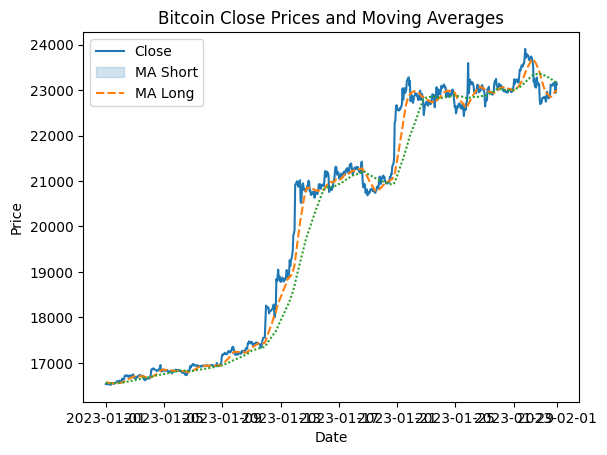

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt
data=calculate_ma(data)
filtered_data= data.loc['2023-01-01':'2023-01-31']
sns.lineplot(data=filtered_data[['close', 'ma_short', 'ma_long']])
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Bitcoin Close Prices and Moving Averages')
plt.legend(['Close', 'MA Short', 'MA Long'])
plt.show()


In [117]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load historical data
display(data)

# Function to calculate moving averages
def calculate_ma(data):
    data['ma_short'] = data['close'].rolling(window=50).mean()
    data['ma_long'] = data['close'].rolling(window=200).mean()
    return data
def strategy(row):
    if row['ma_short'] > row['ma_long']:
        return 'buy'
    elif row['ma_short'] < row['ma_long']:
        return 'sell'
    else:
        return 'hold'
# Initial wallet and parameters
wallet_start = {"usdt": 1000, "coin": 0}
wallet = wallet_start.copy()

parameters = {
    "wallet": 1000,
    "usdt": 1000,
    "coin": 0,
    "taker_fee": 0.0007,
    "maker_fee": 0.0002,
    "balance_percentage_usdt": 0.1,
    "balance_percentage_coin": 1,
    "symbol": "BTC/USDT",
    "num_trades": 0,
    "trade_status": "None",
}
parameters_records = pd.DataFrame(columns=list(parameters.keys()))

# Function to calculate wallet value
def calculate_value_wallet(wallet, row):
    return wallet["usdt"] + wallet["coin"] * row["close"]

# Function to execute a trade
def execute_trade(wallet, row, trade_type, parameters):
    if trade_type == "Buy" and wallet["usdt"] > 0:
        # Calculate amount of coin to buy
        amount_coin = (wallet["usdt"] * parameters["balance_percentage_usdt"]) / row["close"]
        wallet["coin"] += amount_coin * (1 - parameters["taker_fee"])
        wallet["usdt"] -= wallet["usdt"] * parameters["balance_percentage_usdt"]
        trade_status = "Buy"
    elif trade_type == "Sell" and wallet["coin"] > 0:
        # Calculate amount of coin to sell
        amount_usdt = wallet["coin"] * row["close"] * parameters["balance_percentage_coin"]
        wallet["usdt"] += amount_usdt * (1 - parameters["taker_fee"])
        wallet["coin"] -= wallet["coin"] * parameters["balance_percentage_coin"]
        trade_status = "Sell"
    else:
        trade_status = "Hold"
    
    return wallet, trade_status

# Add moving averages to data
data = calculate_ma(data)

# Simulation loop
wallet_values = []
for idx, row in tqdm(data.iterrows(),total=len(data),desc="Simulating"):
    current_wallet_value = calculate_value_wallet(wallet, row)
    parameters["wallet"] = current_wallet_value
    wallet_values.append(current_wallet_value)
    
    # Simple trading strategy: buy if price is above MA, sell if below
    if strategy(row) == "buy":
        wallet, trade_status = execute_trade(wallet, row, "Buy", parameters)
    elif strategy(row) == "sell":
        wallet, trade_status = execute_trade(wallet, row, "Sell", parameters)
    else:
        trade_status = "Hold"
    
    # Update parameters and record trade
    parameters["num_trades"] += 1
    parameters["trade_status"] = trade_status
    parameters_records = pd.concat([parameters_records, pd.DataFrame([parameters])], ignore_index=True)

# Evaluate performance
final_wallet_value = calculate_value_wallet(wallet, data.iloc[-1])
print(f"Final wallet value: {final_wallet_value}")
print(f"Number of trades: {parameters['num_trades']}")

# Plot wallet value over time
data['wallet_value'] = wallet_values
# Créer la colonne close_adjusted
data['close_adjusted'] = data['close'] / data['close'].iloc[0] * wallet_values[0]
print ("ajustement:", 66000/max(wallet_values))
# Afficher les courbes wallet_value et close sur le même graphe
plt.figure(figsize=(12, 6))
sns.lineplot(x=data.index, y='wallet_value', data=data)
sns.lineplot(x=data.index, y='close_adjusted', data=data)

plt.title('Wallet Value and Close Adjusted Over Time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Wallet Value', 'Close Adjusted'])
plt.figure(figsize=(12, 6))
sns.lineplot(x=data.index, y='wallet_value', data=data)
sns.lineplot(x=data.index, y='close_adjusted', data=data)
plt.show()



,open,high,low,close,volume,ma_short,ma_long,short_ma,long_ma,ma,wallet_value,close_adjusted
date,,,,,,,,,,,,
2019-07-10 11:00:00,13073.5,13075.5,13044.5,13064.5,4.8952,NaN,NaN,NaN,NaN,NaN,1000.000000,1000.000000
2019-07-10 12:00:00,13064.5,13064.5,12900.5,13029.0,684.5329,NaN,NaN,NaN,NaN,NaN,1000.000000,997.282713
2019-07-10 13:00:00,13029.0,13127.5,12996.5,13039.5,812.2584,NaN,NaN,NaN,NaN,NaN,1000.000000,998.086417
2019-07-10 14:00:00,13039.5,13065.5,12549.5,12549.5,679.7040,NaN,NaN,NaN,NaN,NaN,1000.000000,960.580198
2019-07-10 15:00:00,12549.5,12552.0,12121.0,12362.0,715.6550,NaN,NaN,NaN,NaN,NaN,1000.000000,946.228329
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-19 23:00:00,63964.2,64095.3,62890.7,63771.2,14875.2400,63021.072,64784.0225,63021.072,64784.0225,63021.072,2501.081197,4881.258372
2024-04-20 00:00:00,63771.2,64216.4,63365.5,63401.3,8151.1100,63056.176,64750.8675,63056.176,64750.8675,63056.176,2501.081197,4852.945004
2024-04-20 01:00:00,63401.3,63741.9,63031.2,63606.8,7683.9050,63103.592,64717.8020,63103.592,64717.8020,63103.592,2501.081197,4868.674653


Simulating:   0%|          | 0/41897 [00:00<?, ?it/s]/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_8239/2887245122.py:90: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  parameters_records = pd.concat([parameters_records, pd.DataFrame([parameters])], ignore_index=True)
Simulating: 100%|██████████| 41897/41897 [00:30<00:00, 1387.57it/s]


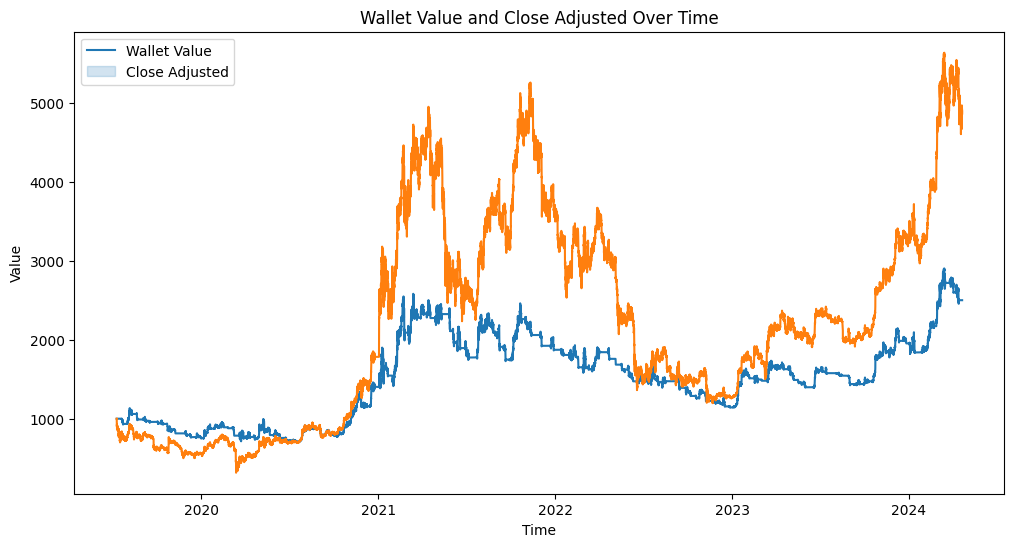

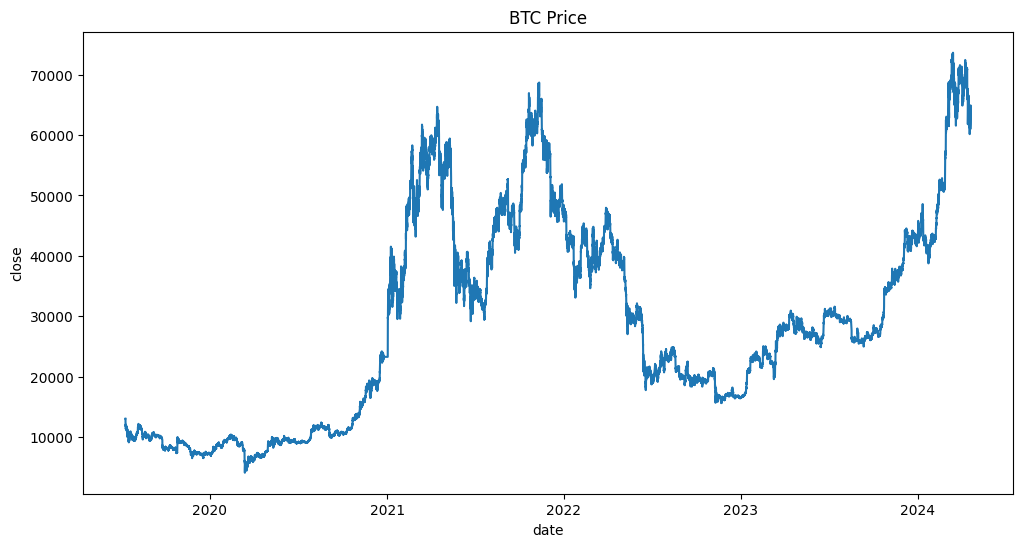

In [119]:
data = calculate_ma(data)

wallet_start, wallet, parameters, parameters_records= set_starting_trading()

wallet_values, parameters_records, final_wallet_value = backtesting(data, wallet_start, parameters,strategy)

data = ajusting_close(data, wallet_values)

plot_wallet_value_and_close(data)